In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pmdarima as pm
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import chi2_contingency
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from io import StringIO
pd.options.mode.chained_assignment = None

2022-04-04 02:10:37.171896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 02:10:37.171939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
######INICIA OS DATAFRAMES PRIMARIOS######

In [4]:
dfEstacao = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/weather_stations_codes.csv', sep = ";", usecols=[0,1])
dfDados = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/conventional_weather_stations_inmet_brazil_1961_2019.csv'
                      , sep=";",
                      usecols=[0,1,3,6,7])

In [6]:
dfEstacao.head()

Nome  Código
0       ACARAU - CE   82294
1  AGUA BRANCA - AL   82989
2      AIMORES - MG   83595
3   ALAGOINHAS - BA   83249
4     ALTAMIRA - PA   82353

In [ ]:
######CRIA TABELA PRINCIPAL######

In [83]:
dfFinal = pd.DataFrame()

for codigo in dfEstacao['Código']:
    dfJoin = dfDados[dfDados.Estacao == codigo].set_index("Estacao").join(dfEstacao.set_index("Código"))
    dfJoin.Data = pd.to_datetime(dfJoin.Data, format='%d/%m/%Y')
    dfGroup = dfJoin.groupby('Data').max()
    dfGroup.Precipitacao = dfGroup.Precipitacao.transform(lambda x: 0.0 if m.isnan(x) else x)
    dfGroup = dfGroup.dropna()
    dfGroup['Data'] = dfGroup.index
    dfGroup['Codigo'] = dfGroup.Nome.transform(lambda x: dfEstacao.loc[dfEstacao.Nome == x, 'Código'].values[0])
    dfGroup = dfGroup.set_index('Codigo')
    dfFinal = pd.concat([dfGroup, dfFinal], ignore_index=False)
        
dfFinal = dfFinal[dfFinal.TempMaxima > dfFinal.TempMinima]        
csvFile = dfFinal.to_csv('dadosPrincipal.csv', date_format='%d/%m/%Y', index=True)

In [ ]:
######CARREGANDO A PLANILHA DE DADOS TRATADOS E ANALISE######

In [2]:
dfDadosPrincipais = pd.read_csv('dadosPrincipais.csv', sep=",")

In [5]:
dfDadosPrincipais

Codigo  Precipitacao  TempMaxima  TempMinima          Nome  \
0         82376           0.0        33.0        20.6  ZE DOCA - MA   
1         82376           0.0        34.2        21.4  ZE DOCA - MA   
2         82376           0.0        33.5        20.9  ZE DOCA - MA   
3         82376           0.0        33.7        21.8  ZE DOCA - MA   
4         82376           0.0        33.9        21.4  ZE DOCA - MA   
...         ...           ...         ...         ...           ...   
3832399   82294           2.6        30.0        23.4   ACARAU - CE   
3832400   82294          62.3        29.4        23.6   ACARAU - CE   
3832401   82294           0.0        32.8        22.8   ACARAU - CE   
3832402   82294           0.0        29.2        22.8   ACARAU - CE   
3832403   82294           0.0        31.0        24.0   ACARAU - CE   

               Data  
0        23/09/1975  
1        25/09/1975  
2        27/09/1975  
3        28/09/1975  
4        29/09/1975  
...             ...  
3832399  13/03/2011  
3832400  14/03/2011  
3832401  15/03/2011  
3832402  16/03/2011  
3832403  17/03/2011  

[3832404 rows x 6 columns]

In [109]:
dfDadosPrincipais.drop(columns=["Codigo"]).describe()

Precipitacao    TempMaxima    TempMinima
count  3.832404e+06  3.832404e+06  3.832404e+06
mean   3.988251e+00  2.970644e+01  1.891808e+01
std    1.085065e+01  4.578027e+00  4.461124e+00
min    0.000000e+00 -2.000000e+00 -9.000000e+00
25%    0.000000e+00  2.730000e+01  1.660000e+01
50%    0.000000e+00  3.040000e+01  1.990000e+01
75%    1.800000e+00  3.280000e+01  2.220000e+01
max    3.779000e+02  4.470000e+01  3.420000e+01

In [112]:
dfDadosPrincipais[dfDadosPrincipais.Precipitacao == dfDadosPrincipais.Precipitacao.max()]


Codigo  Precipitacao  TempMaxima  TempMinima                     Nome  \
596623   82668         377.9        34.7        20.2  SAO FELIX DO XINGU - PA   

              Data  
596623  02/09/1991

In [113]:
dfDadosPrincipais['Data'] = pd.to_datetime(dfDadosPrincipais['Data'], format='%d/%m/%Y')
dfGrafico = dfDadosPrincipais.groupby(dfDadosPrincipais.Data.dt.year).mean()

In [122]:
dfGrafico[dfGrafico.TempMaxima == dfGrafico.TempMaxima.min()]

Codigo  Precipitacao  TempMaxima  TempMinima
Data                                                    
1964  83326.455677      4.506185   27.747409   17.145981

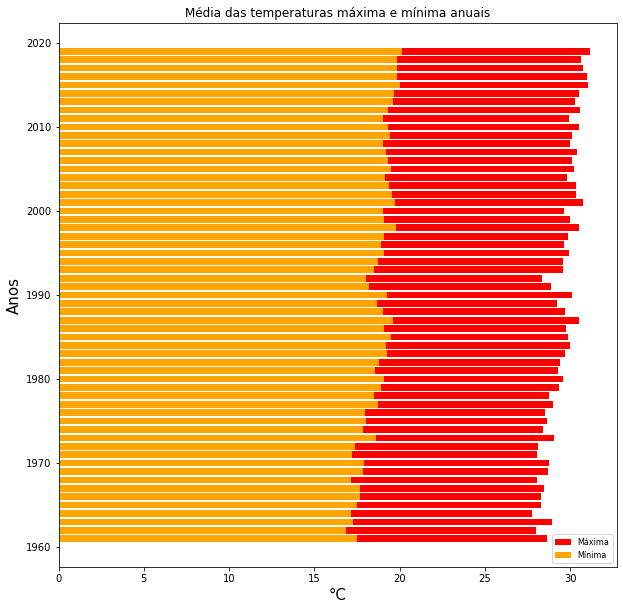

In [115]:
plt.figure(figsize=(10,10))

plt.barh(dfGrafico.index, dfGrafico.TempMaxima, height = 0.8, label='Máxima', color='red')
plt.barh(dfGrafico.index, dfGrafico.TempMinima, height = 0.8, label='Mínima', color='orange')
plt.title('Média das temperaturas máxima e mínima anuais')
plt.xlabel('°C', fontsize=15)
plt.ylabel('Anos', fontsize=15)
plt.legend(fontsize=8)

plt.savefig('TemperaturaBarras.png')
    
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


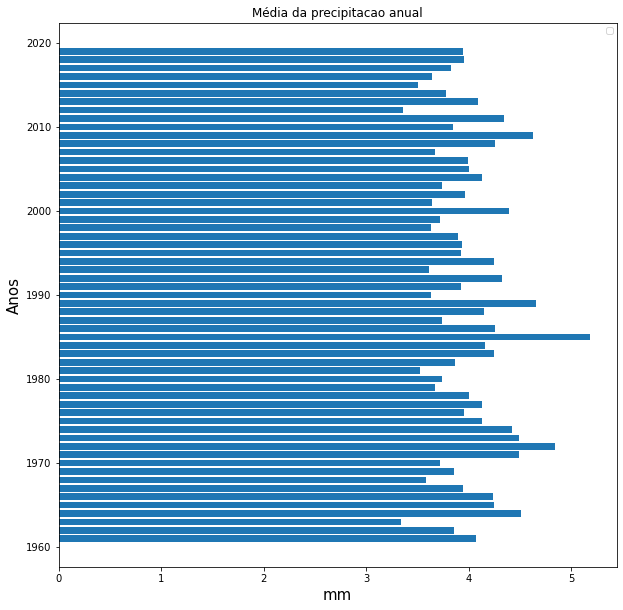

In [116]:
plt.figure(figsize=(10,10))

plt.barh(dfGrafico.index, dfGrafico.Precipitacao, height = 0.8)
plt.title('Média da precipitacao anual')
plt.xlabel('mm', fontsize=15)
plt.ylabel('Anos', fontsize=15)
plt.legend(loc='best', fontsize=8)

plt.savefig('PrecipitacaoBarras.png')
    
plt.show()

In [123]:
dfGrafico.TempMaxima.mean()

29.54911412828082

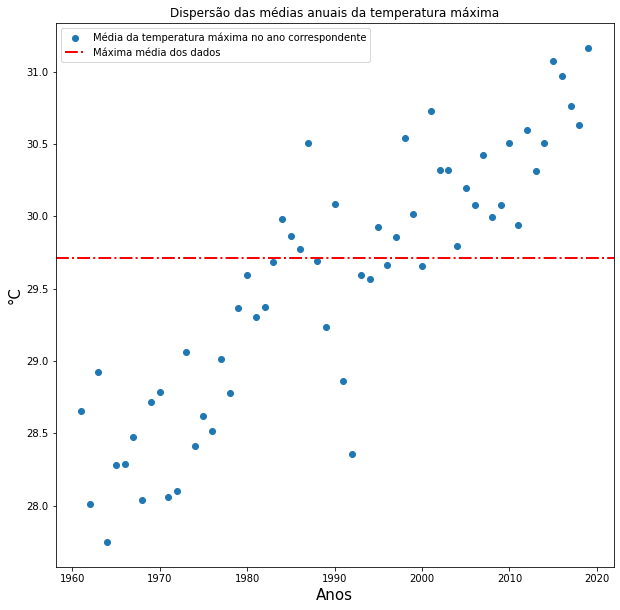

In [124]:
plt.figure(figsize=(10,10))

plt.scatter(dfGrafico.index, dfGrafico.TempMaxima, label='Média da temperatura máxima no ano correspondente')
plt.axhline(y=29.71, color='red', linestyle='-.', linewidth=2, label='Máxima média dos dados')
plt.title('Dispersão das médias anuais da temperatura máxima')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize=10)

plt.savefig('TemperaturaMaximaDispersao.png')
    
plt.show()

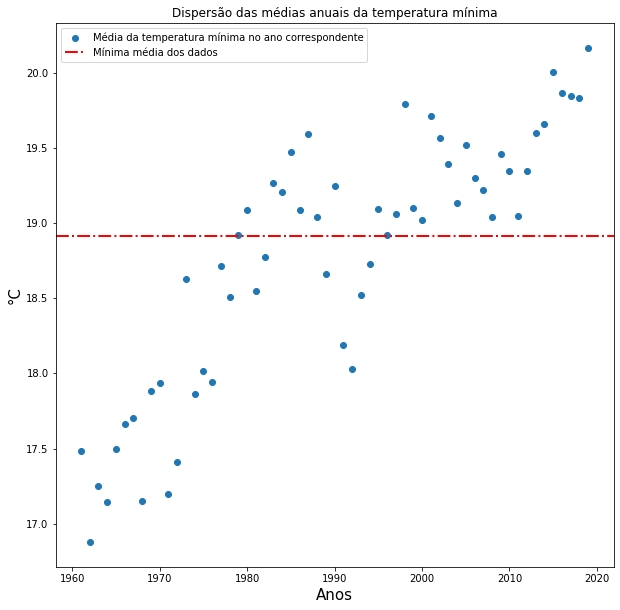

In [128]:
plt.figure(figsize=(10,10))

plt.scatter(dfGrafico.index, dfGrafico.TempMinima, label='Média da temperatura mínima no ano correspondente')
plt.axhline(y=18.91, color='red', linestyle='-.', linewidth=2, label='Mínima média dos dados')
plt.title('Dispersão das médias anuais da temperatura mínima')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize=10)

plt.savefig('TemperaturaMinimaDispersao.png')
    
plt.show()

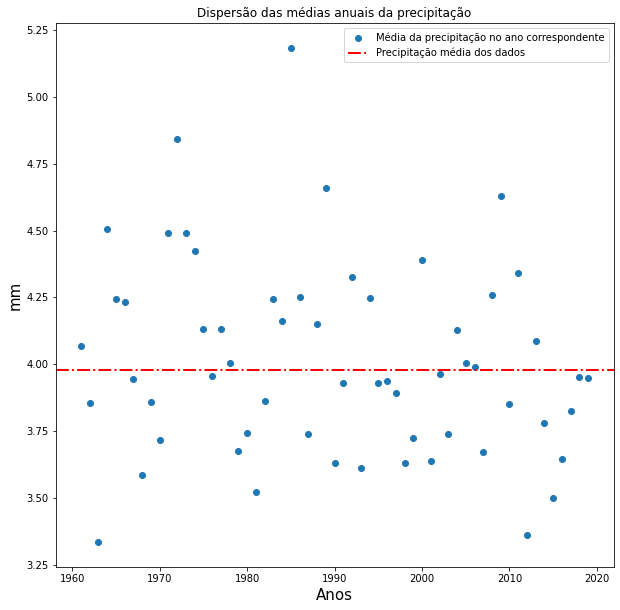

In [126]:
plt.figure(figsize=(10,10))

plt.scatter(dfGrafico.index, dfGrafico.Precipitacao, label='Média da precipitação no ano correspondente')
plt.axhline(y=3.98, color='red', linestyle='-.', linewidth=2, label='Precipitação média dos dados')
plt.title('Dispersão das médias anuais da precipitação')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('mm', fontsize=15)
plt.legend(fontsize=10)

plt.savefig('PrecipitacaoDispersao.png')
    
plt.show()

In [ ]:
###MEDIA MENSAL PARA CADA ESTADO###

In [3]:
def agrupaPorMes(estado):
    dfDadosPrincipais['Data'] = pd.to_datetime(dfDadosPrincipais['Data'], format='%d/%m/%Y')

    dfEstado = dfDadosPrincipais[dfDadosPrincipais.Nome.str.contains('- ' + estado)].drop(columns=['Codigo'])

    dfMaxima = pd.DataFrame()
    dfMinima = pd.DataFrame()
    dfPrecipitacao = pd.DataFrame()

    for ano in range(1961, 2020):
        dfAgrupado = dfEstado[dfEstado.Data.dt.to_period('Y') == str(ano)].groupby([dfEstado['Data'].dt.month]).mean()
        dfMaxima = pd.concat([dfMaxima, dfAgrupado.TempMaxima.to_frame().transpose()], ignore_index=True)
        dfMinima = pd.concat([dfMinima, dfAgrupado.TempMinima.to_frame().transpose()], ignore_index=True)
        dfPrecipitacao = pd.concat([dfPrecipitacao, dfAgrupado.Precipitacao.to_frame().transpose()], ignore_index=True)
    
    dfMaxima.set_index(pd.Index(range(1961,2020)), inplace=True)
    dfMinima.set_index(pd.Index(range(1961,2020)), inplace=True)
    dfPrecipitacao.set_index(pd.Index(range(1961,2020)), inplace=True)
    
    dfMaxima = dfMaxima[[1,2,3,4,5,6,7,8,9,10,11,12]]
    dfMinima = dfMinima[[1,2,3,4,5,6,7,8,9,10,11,12]]
    dfPrecipitacao = dfPrecipitacao[[1,2,3,4,5,6,7,8,9,10,11,12]]
    
    return dfMaxima, dfMinima, dfPrecipitacao

In [4]:
def trataDataFrames(dfMaxima, dfMinima, dfPrecipitacao):    
    dfMaxima.dropna(thresh=1, inplace = True)
    dfMinima.dropna(thresh=1, inplace = True)
    dfPrecipitacao.dropna(thresh=1, inplace = True)
    
    for mes in range(1,13):
        dfMaxima.update(dfMaxima[mes].fillna(dfMaxima[mes].mean()))
        dfMinima.update(dfMinima[mes].fillna(dfMinima[mes].mean()))
        dfPrecipitacao.update(dfPrecipitacao[mes].fillna(dfPrecipitacao[mes].mean()))

In [5]:
def editaGrafico(ax, titulo, dataFrame, quantidadeVariaveis):
    angles = np.linspace(0, 2 * np.pi, quantidadeVariaveis, endpoint=False).tolist()
    angles += angles[:1]
    maxValues = dataFrame.describe().loc["max"].tolist()
    maxValues += maxValues[:1]
    minValues = dataFrame.describe().loc["min"].tolist()
    minValues += minValues[:1]
    meanValues = dataFrame.describe().loc["mean"].tolist()
    meanValues += meanValues[:1]
    
    ax.plot(angles, maxValues, color='red', linewidth=2, label='Máxima')
    ax.plot(angles, minValues, color='blue', linewidth=2, label='Mínima')
    ax.plot(angles, meanValues, color='orange', linewidth=2, label='Média')
    
    ax.set_ylim(dataFrame.describe().loc["min"].min(), dataFrame.describe().loc["max"].max())
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles), ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez", "Jan"])

    ax.set_title(titulo, y=1.08)

    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), prop={'size': 10})

/tmp/ipykernel_6304/613964765.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 20), subplot_kw=dict(polar=True))


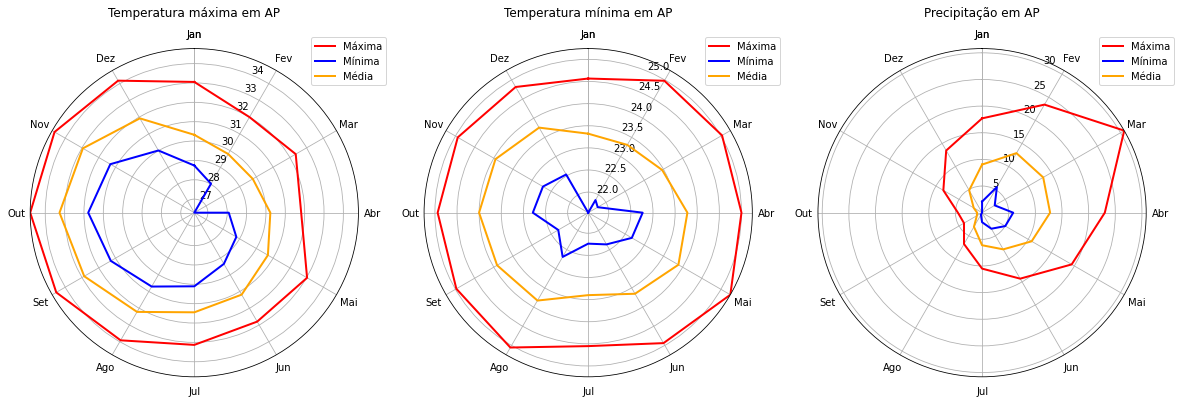

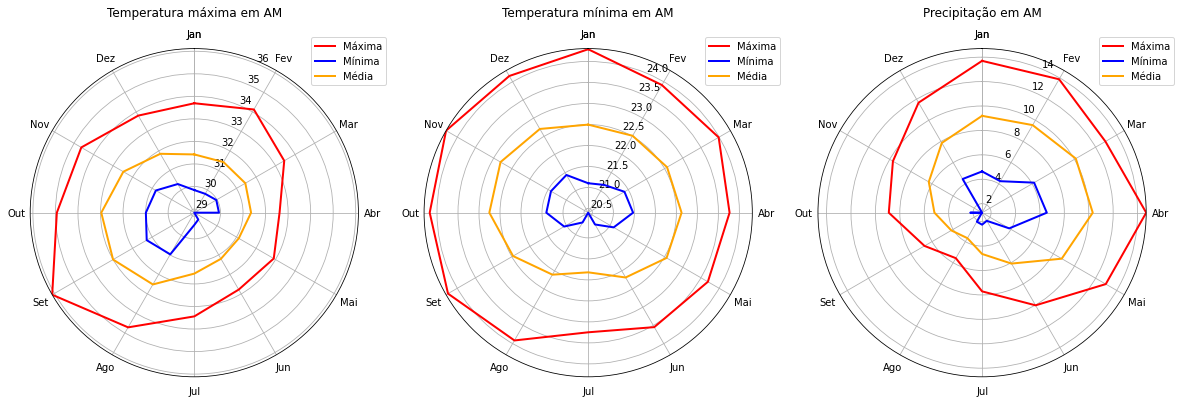

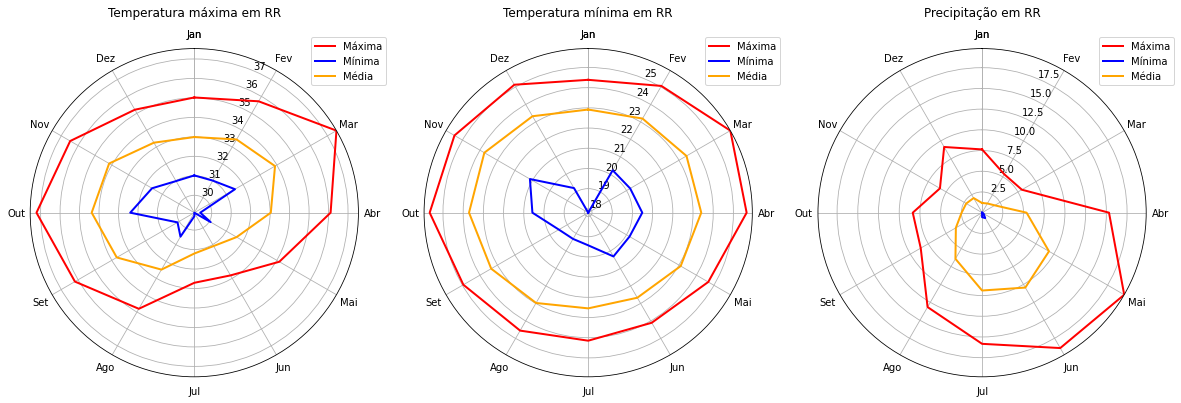

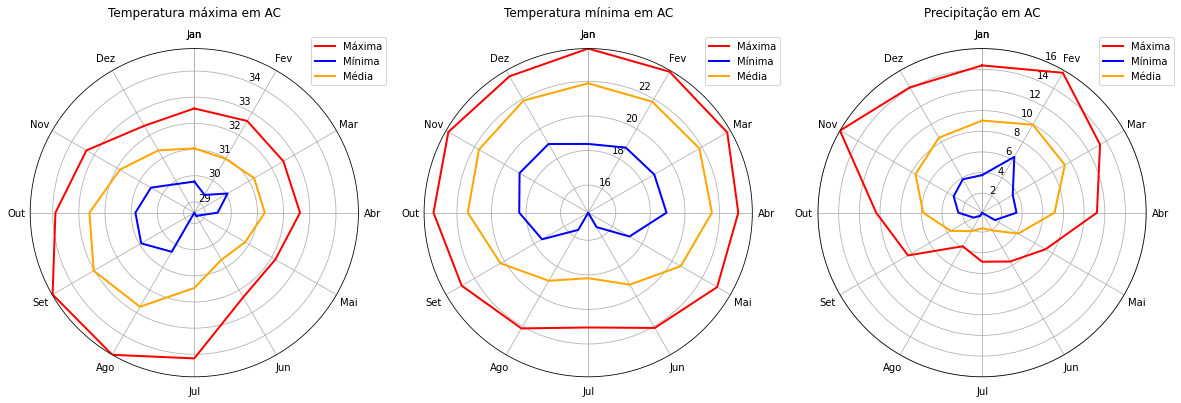

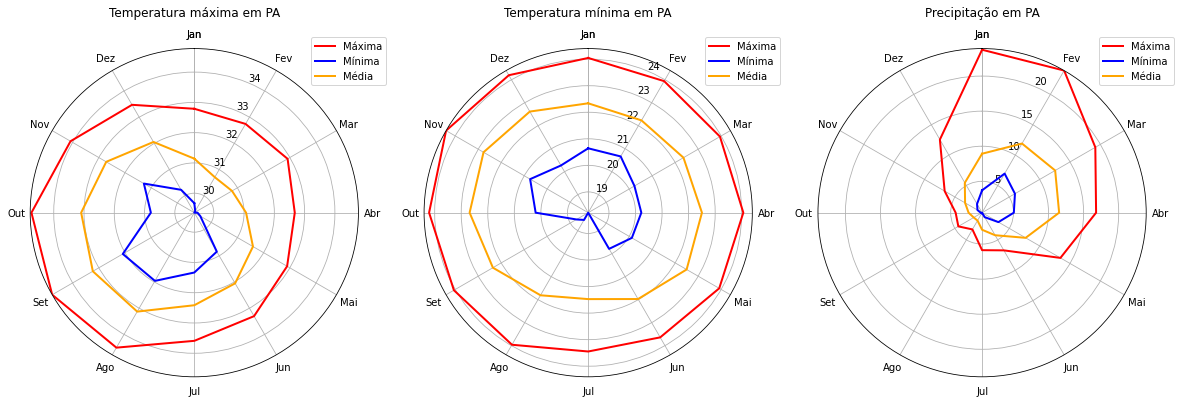

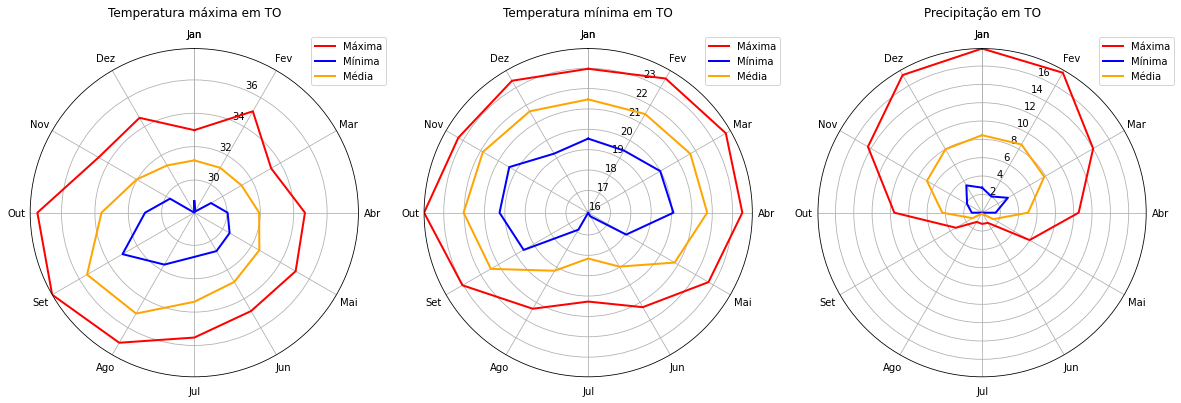

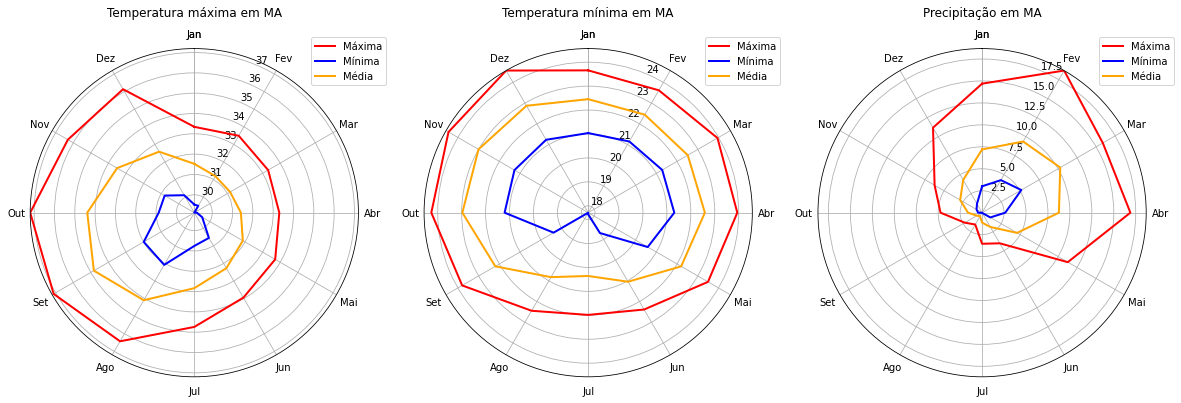

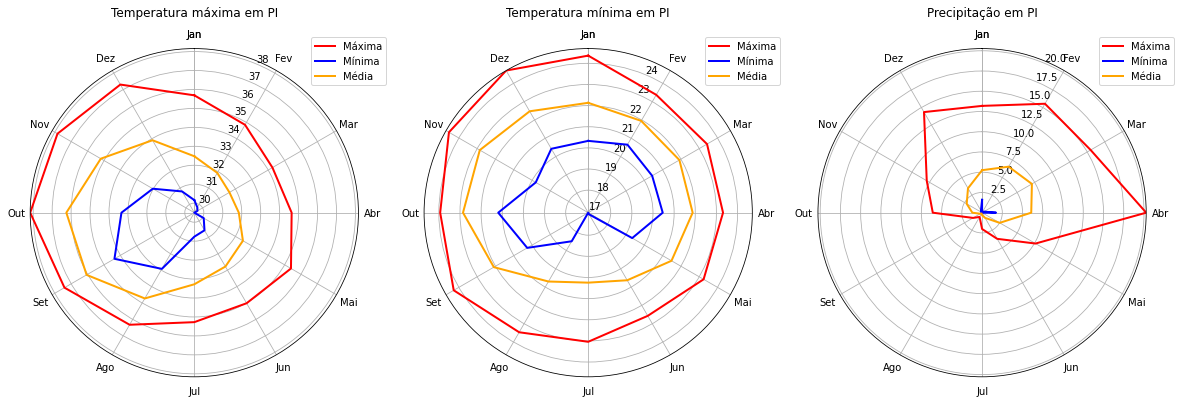

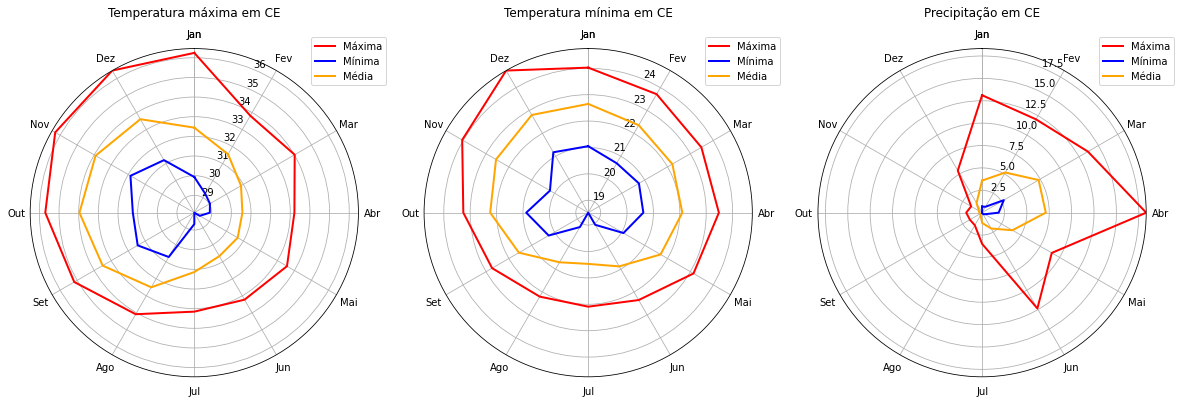

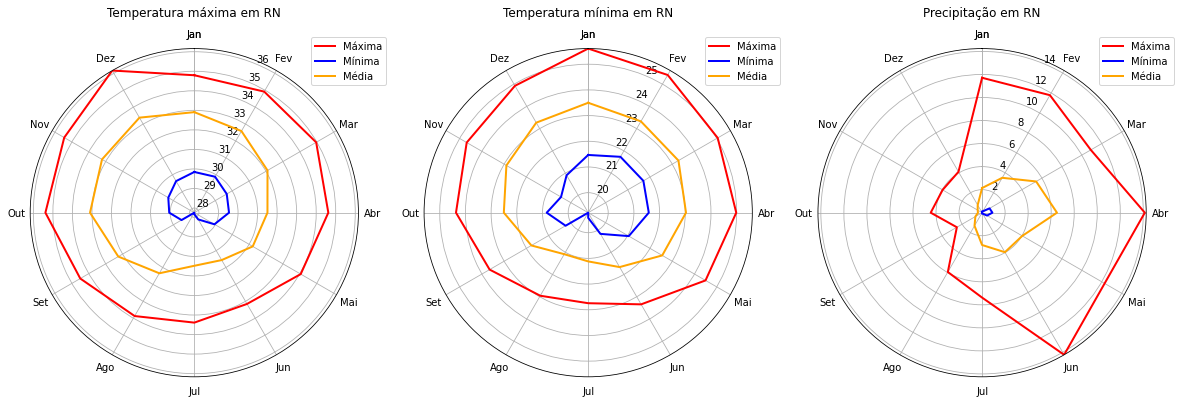

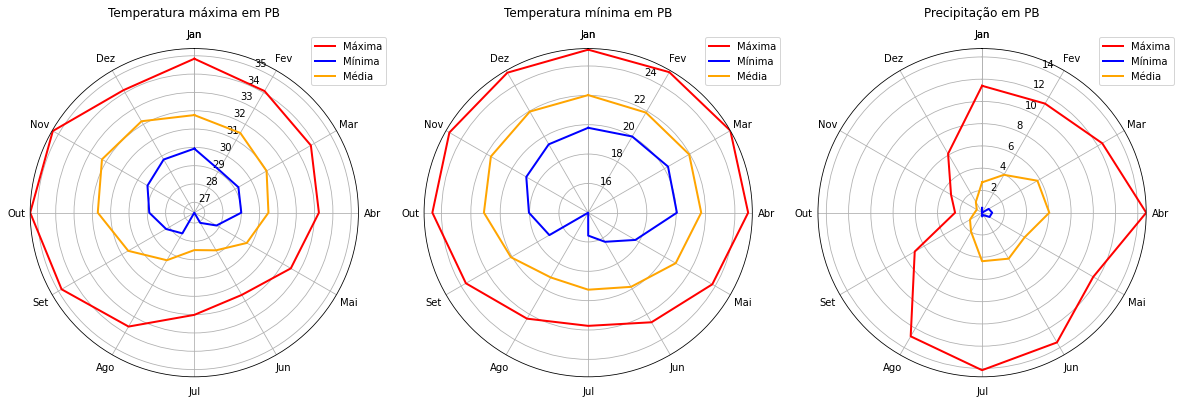

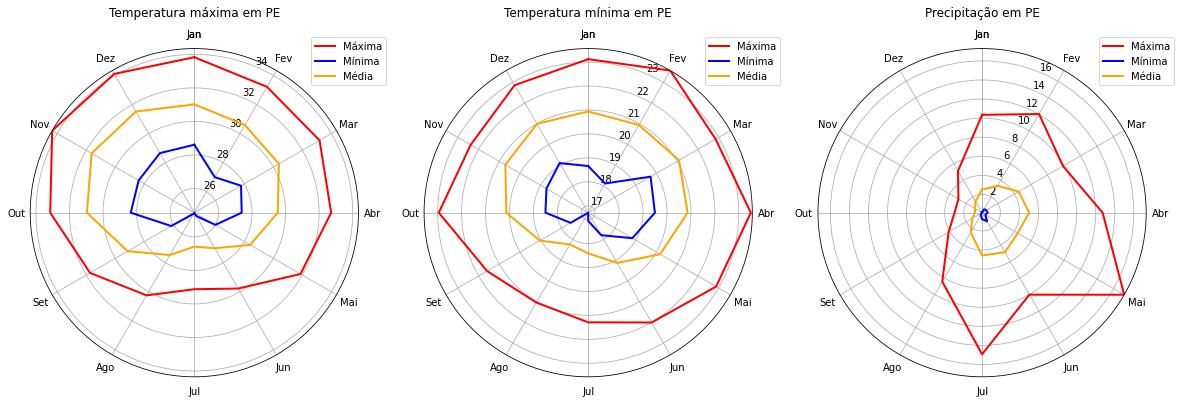

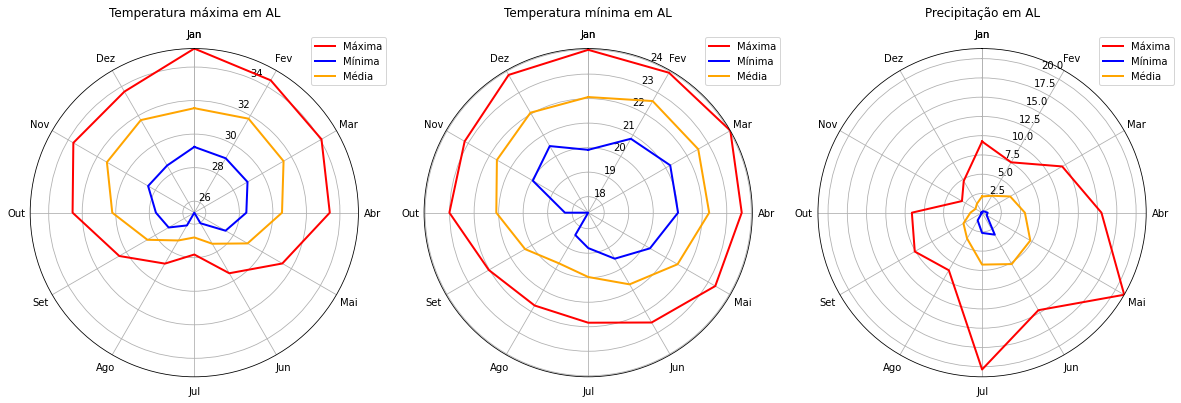

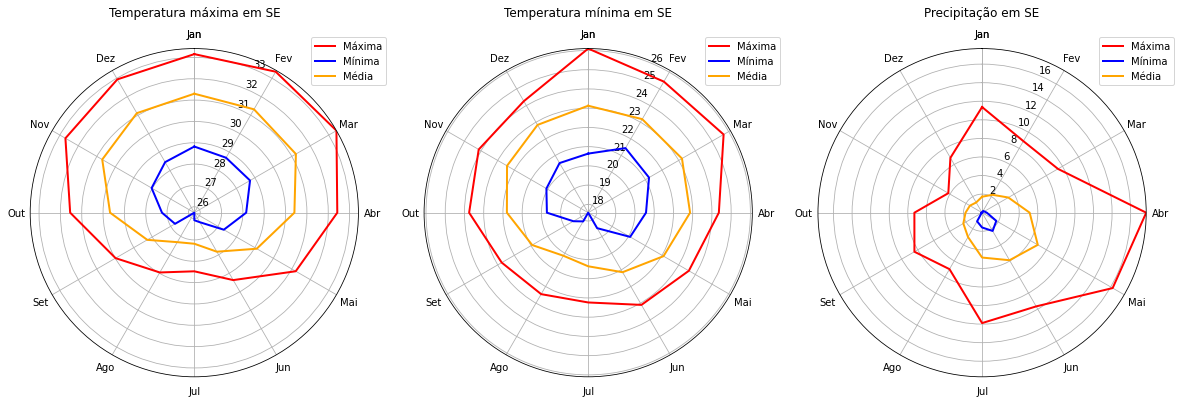

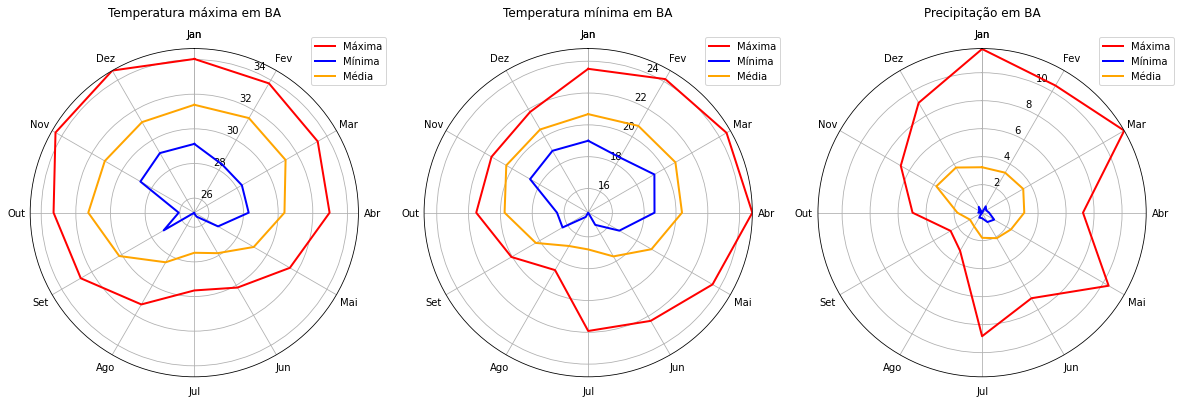

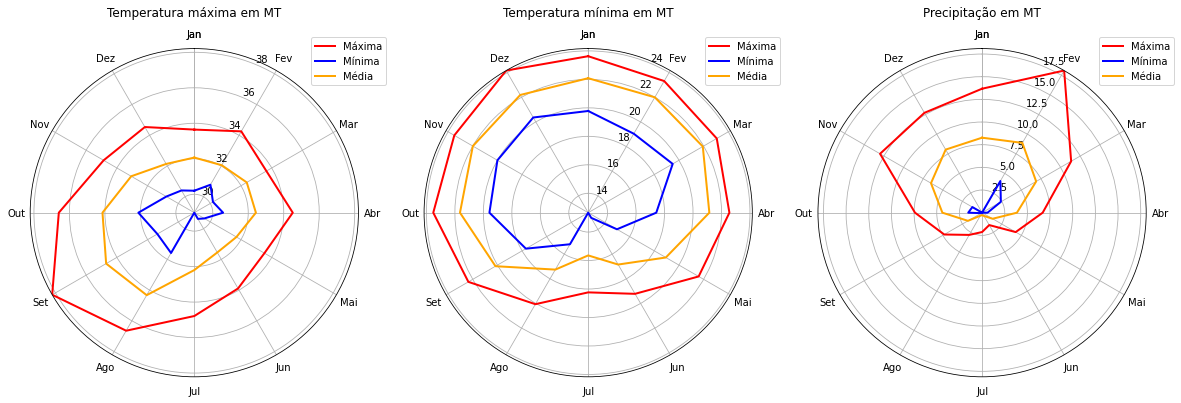

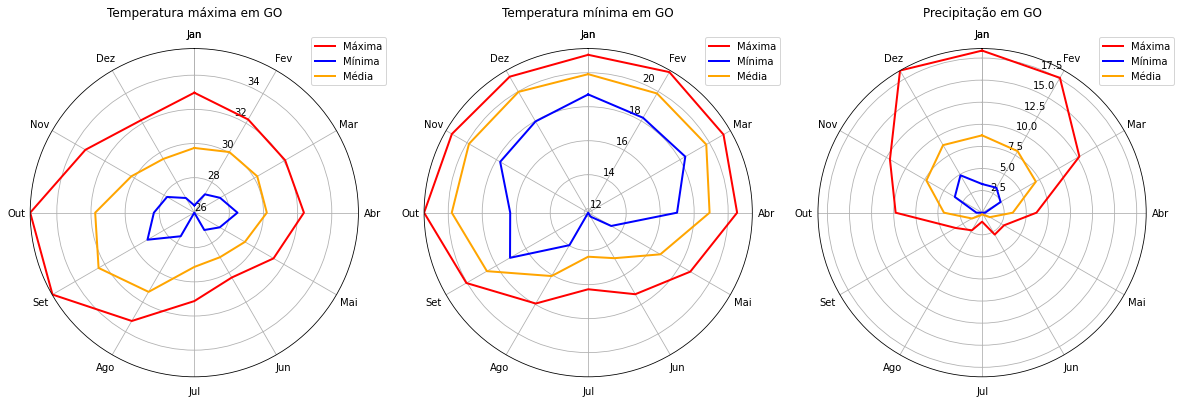

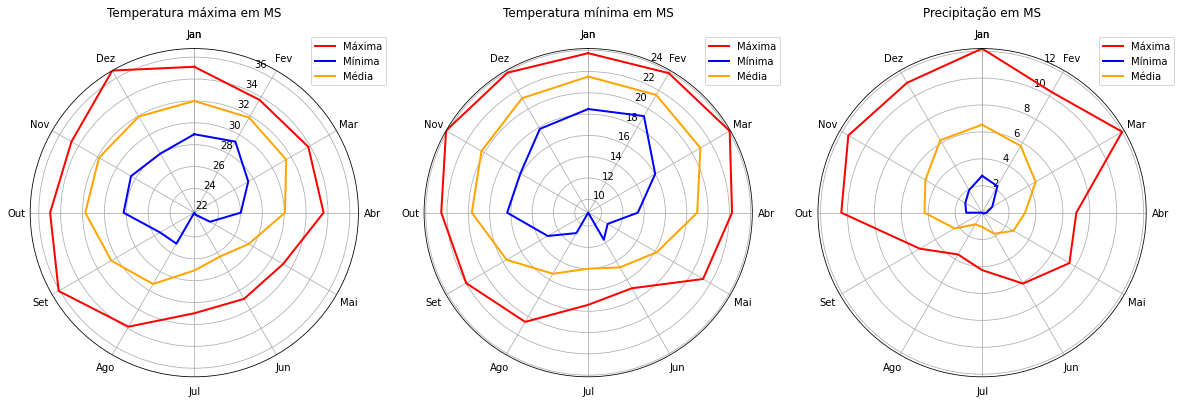

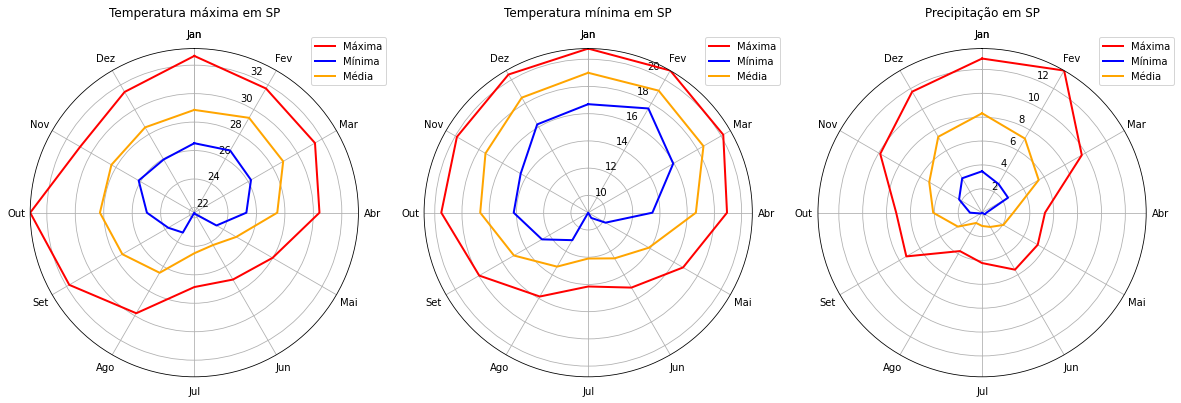

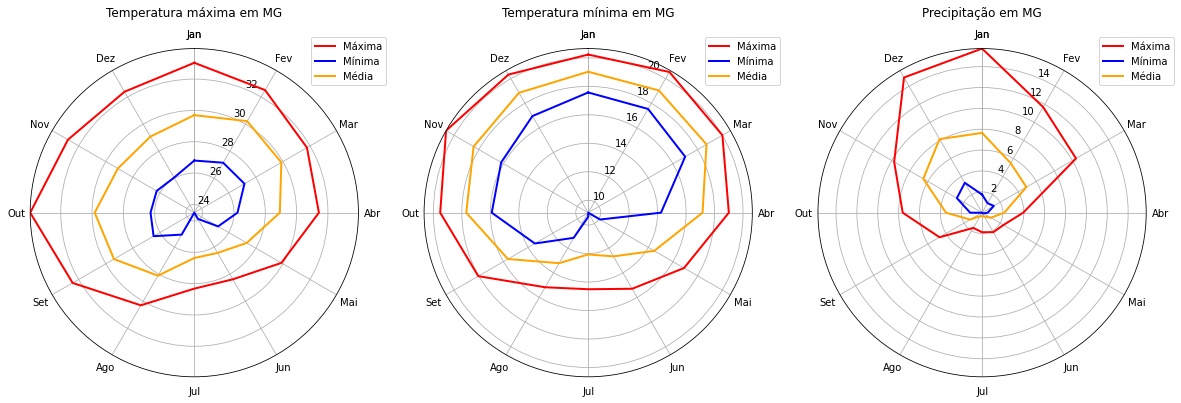

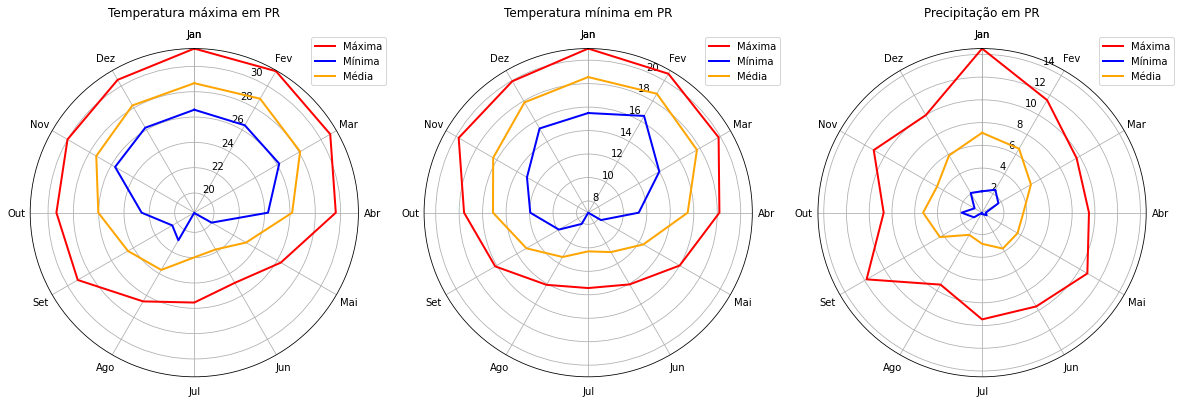

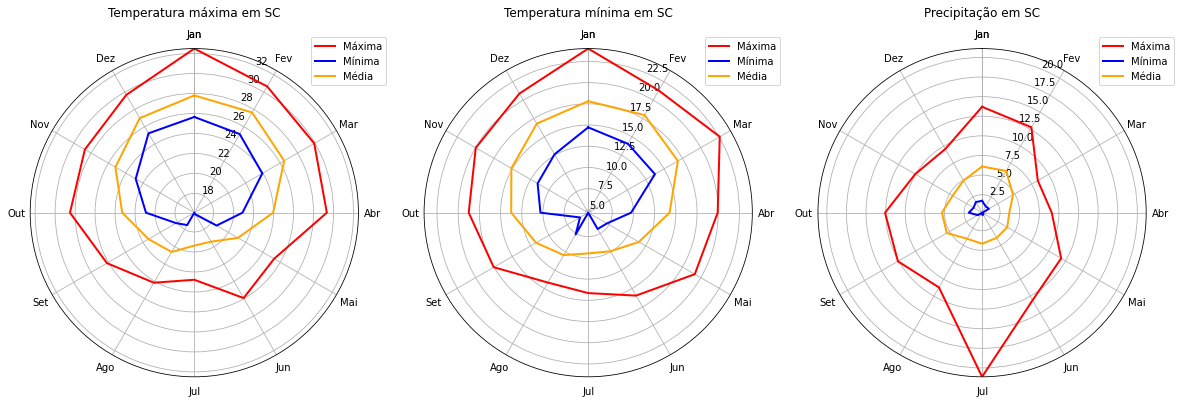

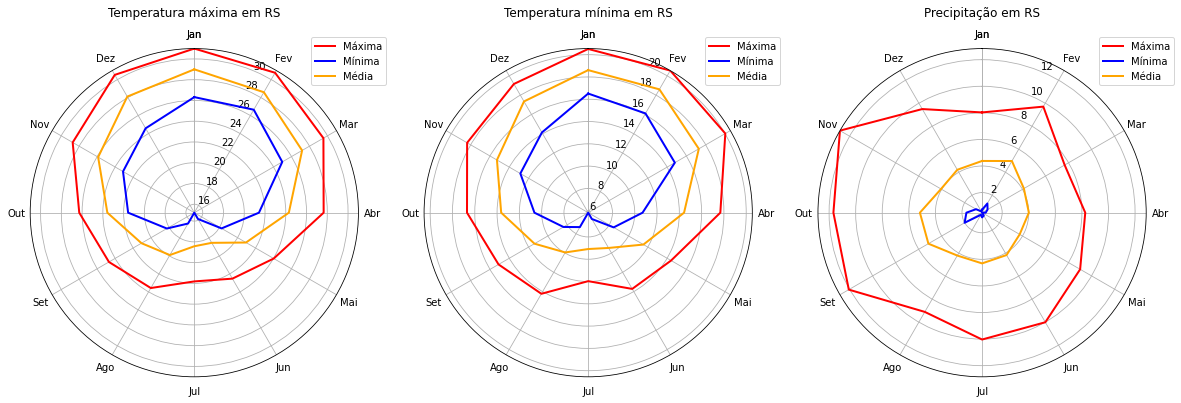

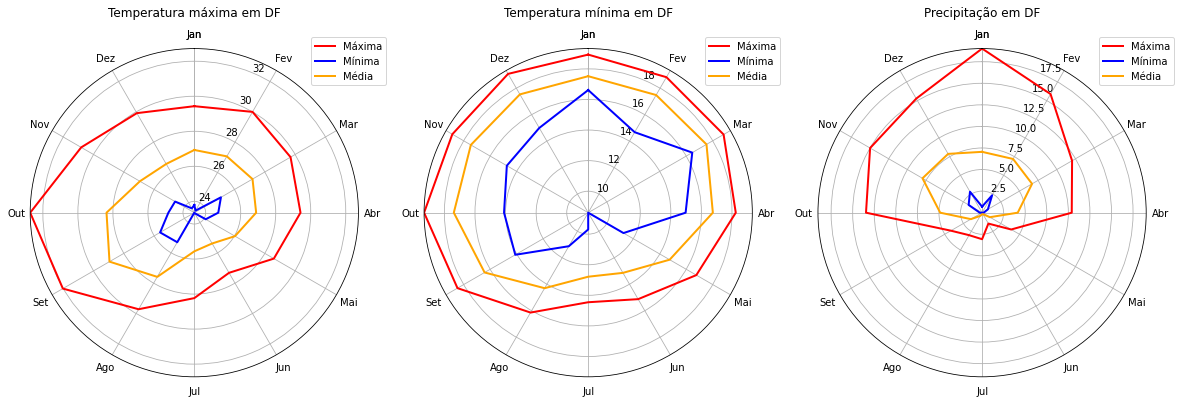

In [407]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'PR', 'SC', 'RS', 'DF']
colunas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    
for estado in estados:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 20), subplot_kw=dict(polar=True))
    dfMaxima, dfMinima, dfPrecipitacao = agrupaPorMes(estado)
    trataDataFrames(dfMaxima, dfMinima, dfPrecipitacao)
    editaGrafico(ax1, 'Temperatura máxima em ' + estado, dfMaxima, len(colunas))
    editaGrafico(ax2, 'Temperatura mínima em ' + estado, dfMinima, len(colunas))
    editaGrafico(ax3, 'Precipitação em ' + estado, dfPrecipitacao, len(colunas))
    fig.savefig('Aranha' + estado + '.png', bbox_inches ="tight", format='png')

In [ ]:
###CORRELAÇÂO###

In [18]:
dfDadosPrincipais.drop(columns=['Codigo', 'Nome', 'Data']).corr()

Precipitacao  TempMaxima  TempMinima
Precipitacao      1.000000   -0.147270    0.063457
TempMaxima       -0.147270    1.000000    0.680019
TempMinima        0.063457    0.680019    1.000000

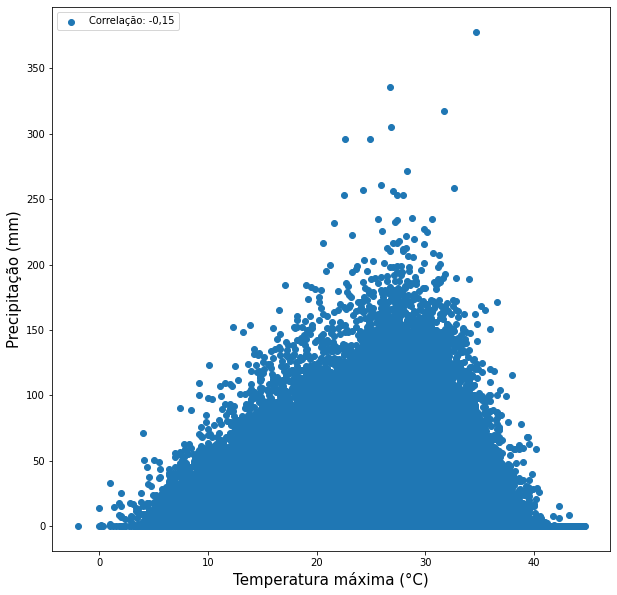

In [29]:
plt.figure(figsize=(10,10))

plt.scatter(dfDadosPrincipais.TempMaxima, dfDadosPrincipais.Precipitacao, label='Correlação: -0,15')
plt.xlabel('Temperatura máxima (°C)', fontsize=15)
plt.ylabel('Precipitação (mm)', fontsize=15)
plt.legend(loc="upper left", fontsize=10)

plt.savefig('correlacaoMaxPre.png')
    
plt.show()

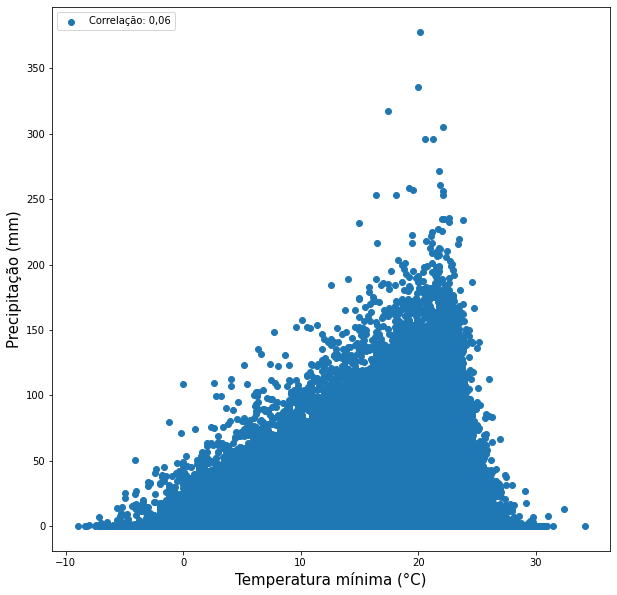

In [27]:
plt.figure(figsize=(10,10))

plt.scatter(dfDadosPrincipais.TempMinima, dfDadosPrincipais.Precipitacao, label='Correlação: 0,06')
plt.xlabel('Temperatura mínima (°C)', fontsize=15)
plt.ylabel('Precipitação (mm)', fontsize=15)
plt.legend(loc="upper left", fontsize=10)

plt.savefig('correlacaoMinPre.png')
    
plt.show()

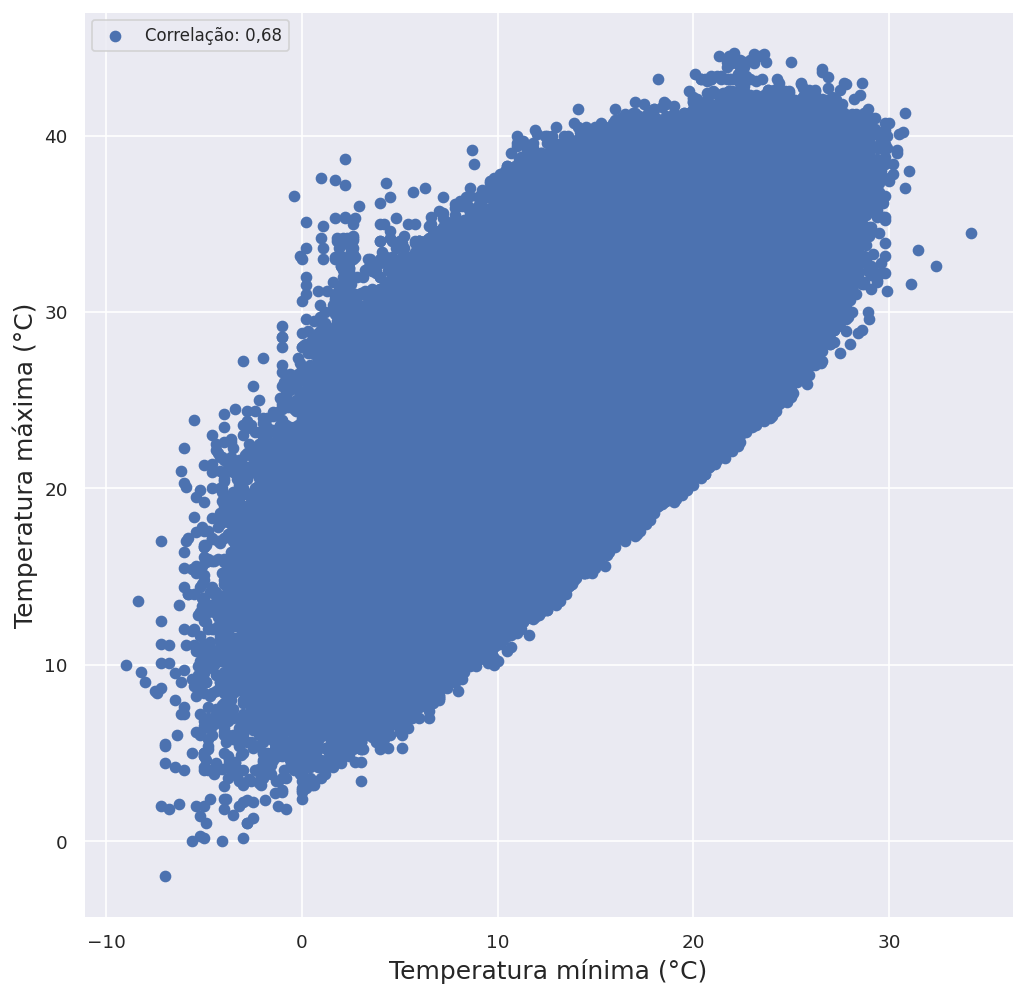

In [52]:
plt.figure(figsize=(10,10))

plt.scatter(dfDadosPrincipais.TempMinima, dfDadosPrincipais.TempMaxima, label='Correlação: 0,68')
plt.xlabel('Temperatura mínima (°C)', fontsize=15)
plt.ylabel('Temperatura máxima (°C)', fontsize=15)
plt.legend(loc="upper left", fontsize=10)

# plt.savefig('correlacaoMaxMin.png')
    
plt.show()

In [ ]:
######PLANILHA DE SERIE TEMPORAL######

In [3]:
dfDadosPrincipais['Data'] = pd.to_datetime(dfDadosPrincipais['Data'], format='%d/%m/%Y')
dfSerie = dfDadosPrincipais.drop(columns=['Codigo']).groupby(dfDadosPrincipais['Data']).mean()
dfSerie['Data'] = dfSerie.index

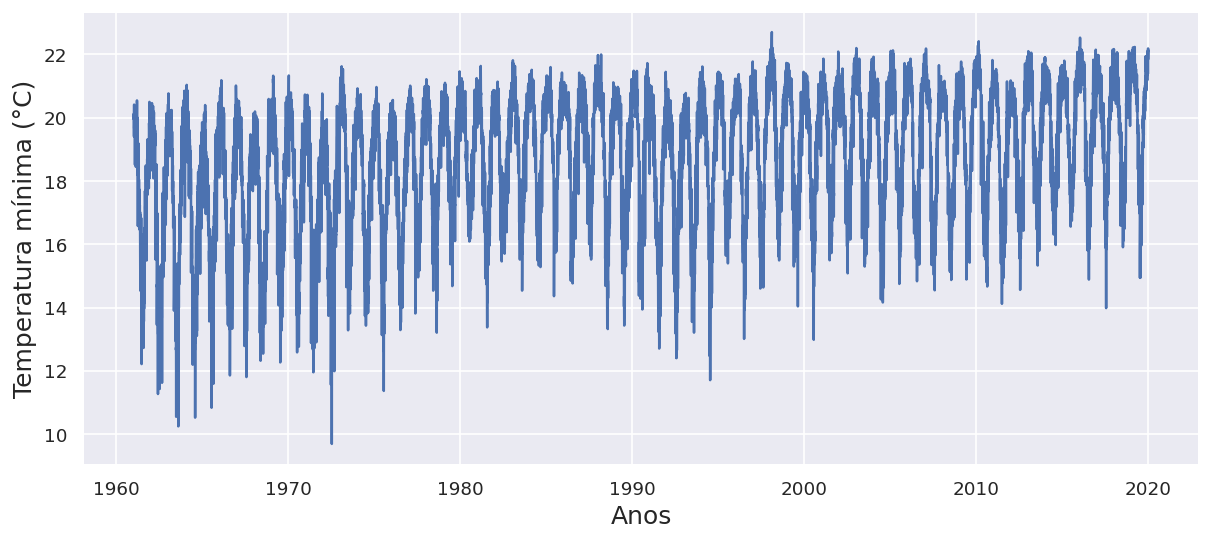

In [62]:
dfPlot = dfSerie

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfPlot.index, dfPlot.TempMinima)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura mínima (°C)', fontsize=15)
plt.savefig('SerieTempMin.png')

In [ ]:
dfPlot = dfSerie.loc['1970':'1975']

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfPlot.index, dfPlot.TempMinima)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura mínima (°C)', fontsize=15)
plt.savefig('SerieTempMin19701975.png')

In [ ]:
dfPlot = dfSerie

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfPlot.index, dfPlot.TempMaxima)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura máxima (°C)', fontsize=15)
plt.savefig('SerieTempMax.png')

In [ ]:
dfPlot = dfSerie.loc['1970':'1975']

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfPlot.index, dfPlot.TempMinima)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura mínima (°C)', fontsize=15)
plt.savefig('SerieTempMax19701975.png')

In [ ]:
dfPlot = dfSerie

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfPlot.index, dfPlot.Precipitacao)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Precipitação (mm)', fontsize=15)
plt.savefig('SeriePrecipitacao.png')

In [ ]:
dfPlot = dfSerie.loc['1970':'1975']

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfPlot.index, dfPlot.Precipitacao)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Precipitação (mm)', fontsize=15)
plt.savefig('SeriePrecipitacao19701975.png')

In [ ]:
###REGRESSÃO LINEAR###

In [169]:
dfDadosPrincipais['Data'] = pd.to_datetime(dfDadosPrincipais['Data'], format='%d/%m/%Y')
dfGrafico = dfDadosPrincipais.drop(columns=['Codigo']).groupby(dfDadosPrincipais.Data.dt.year).mean()

# dfGraficos['Media'] = dfBrasilPrecipitacao.drop(columns=['Ano'], axis=1).mean(axis=1)
# dfGraficos['Ano'] = dfBrasilPrecipitacao.Ano.transform(lambda x: float(x))
# dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
        
Y = dfGrafico.TempMaxima.values.reshape(-1, 1)  #dependent variable vector
X = dfGrafico.index.values.reshape(-1, 1)
xTreino, xTeste, yTreino, yTeste = train_test_split(X,Y,test_size=0.3)
regressao = LinearRegression()
regressao.fit(xTreino, yTreino)
r = regressao.score(xTreino, yTreino)
        
while(r < 0.88):
    xTreino, xTeste, yTreino, yTeste = train_test_split(X,Y,test_size=0.3)
    regressao = LinearRegression()
    regressao.fit(xTreino, yTreino)
    r = regressao.score(xTreino, yTreino)

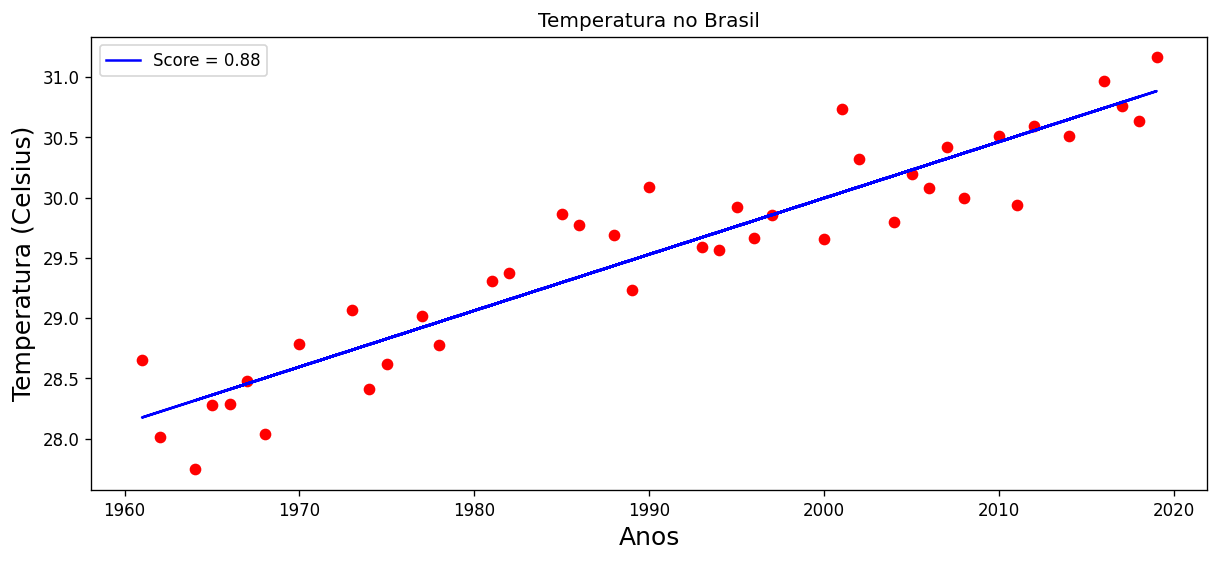

In [171]:
fig = plt.figure()
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.scatter(xTreino, yTreino, color='red') # plotting the observation line
plt.title('Temperatura no Brasil')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura (Celsius)', fontsize=15)
plt.plot(xTreino, regressao.predict(xTreino), color='blue', label = "Score = " + str(np.round(r,3)))# plotting the regression line
plt.legend()
fig.savefig('regressaoTreinoTempMax.png', format='png')

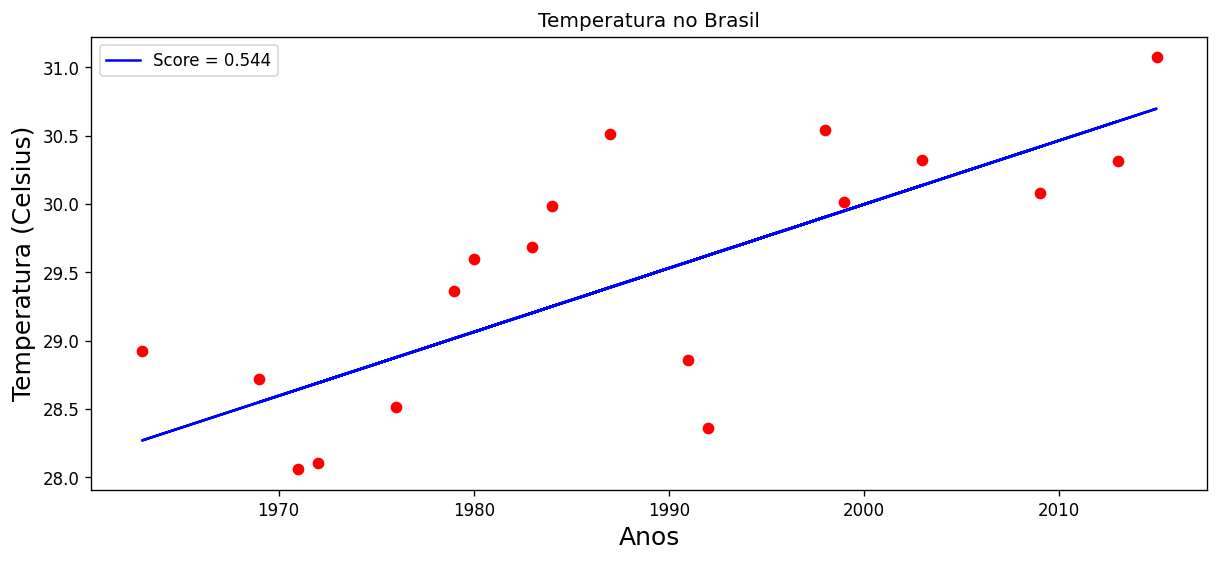

In [172]:
fig = plt.figure()
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.scatter(xTeste, yTeste, color='red') # plotting the observation line
plt.title('Temperatura no Brasil')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura (Celsius)', fontsize=15)
plt.plot(xTeste, regressao.predict(xTeste), color='blue', label = "Score = " + str(np.round(regressao.score(xTeste, yTeste),3)))# plotting the regression line
plt.legend()
fig.savefig('regressaoTesteTempMax.png', format='png')

In [174]:
mean_squared_error(regressao.predict(xTeste), yTeste)

0.3663501871601441

In [ ]:
mean_squared_error(regressao.predict(xTreino), yTreino)

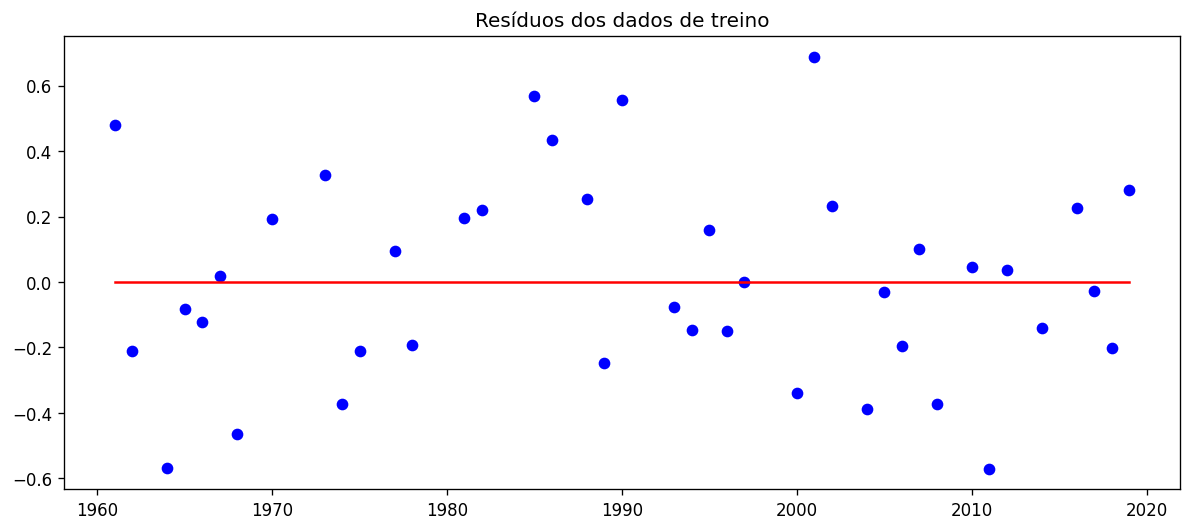

In [182]:
residuo = yTreino - regressao.predict(xTreino)

fig = plt.figure()
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.scatter(xTreino, residuo, color='blue')
plt.plot(dfGrafico.index, np.zeros(59), color = 'red')
plt.title('Resíduos dos dados de treino')
fig.savefig('residuosTreinoTempMax.png', format='png')

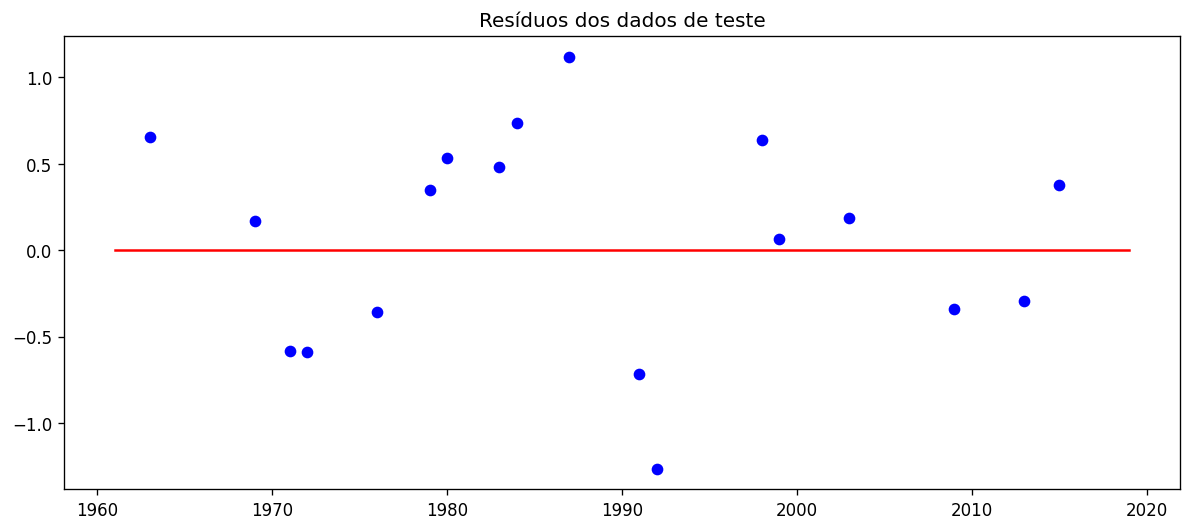

In [183]:
residuo = yTeste - regressao.predict(xTeste)

fig = plt.figure()
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.scatter(xTeste, residuo, color='blue')
plt.plot(dfGrafico.index, np.zeros(59), color = 'red')
plt.title('Resíduos dos dados de teste')
fig.savefig('residuosTesteTempMax.png', format='png')

In [ ]:
##########PLANILHA DE TEMPERATURAS COM MEDIAS MENSAIS POR ANO###############

In [4]:
dfMes = pd.DataFrame()
dfMes['Data'] = 'iniciando'
for ano in range(1961,2020):
    mes = 1
    while(mes<13):
        if(mes<10):
            dfMes = pd.concat([dfMes, dfSerie.groupby(dfSerie.Data.astype(str).str.contains(str(ano) + '-0' + str(mes))).mean()])
            dfMes.iloc[len(dfMes)-1,0] = str(ano) + "-0" +str(mes)
        else:
            dfMes = pd.concat([dfMes, dfSerie.groupby(dfSerie.Data.astype(str).str.contains(str(ano) + '-' + str(mes))).mean()])
            dfMes.iloc[len(dfMes)-1,0] = str(ano) + "-" +str(mes)
        dfMes = dfMes.loc[dfMes.index == True]
    
        mes = mes + 1

In [7]:
dfMes

Data  Precipitacao  TempMaxima  TempMinima
True 1961-01-01      7.746394   29.624998   19.835929
True 1961-02-01      7.071101   29.678359   19.484267
True 1961-03-01      5.591029   29.377867   18.993924
True 1961-04-01      4.771871   28.446296   17.919926
True 1961-05-01      3.010639   27.148360   16.162628
...         ...           ...         ...         ...
True 2019-08-01      1.385647   29.998313   17.719379
True 2019-09-01      1.522756   32.086474   19.573852
True 2019-10-01      2.888074   32.474893   20.661971
True 2019-11-01      3.763294   32.438242   21.437754
True 2019-12-01      4.188972   32.476651   21.703150

[708 rows x 4 columns]

In [6]:
dfMes['Data'] = pd.to_datetime(dfMes['Data'],format='%Y-%m')

In [ ]:
###SARIMA###

In [6]:
df = pd.DataFrame()
df['Data'] = dfMes.Data
df['Maxima'] = dfMes.TempMaxima
df = df.set_index('Data')

In [7]:
df

Maxima
Data                 
1961-01-01  29.624998
1961-02-01  29.678359
1961-03-01  29.377867
1961-04-01  28.446296
1961-05-01  27.148360
...               ...
2019-08-01  29.998313
2019-09-01  32.086474
2019-10-01  32.474893
2019-11-01  32.438242
2019-12-01  32.476651

[708 rows x 1 columns]

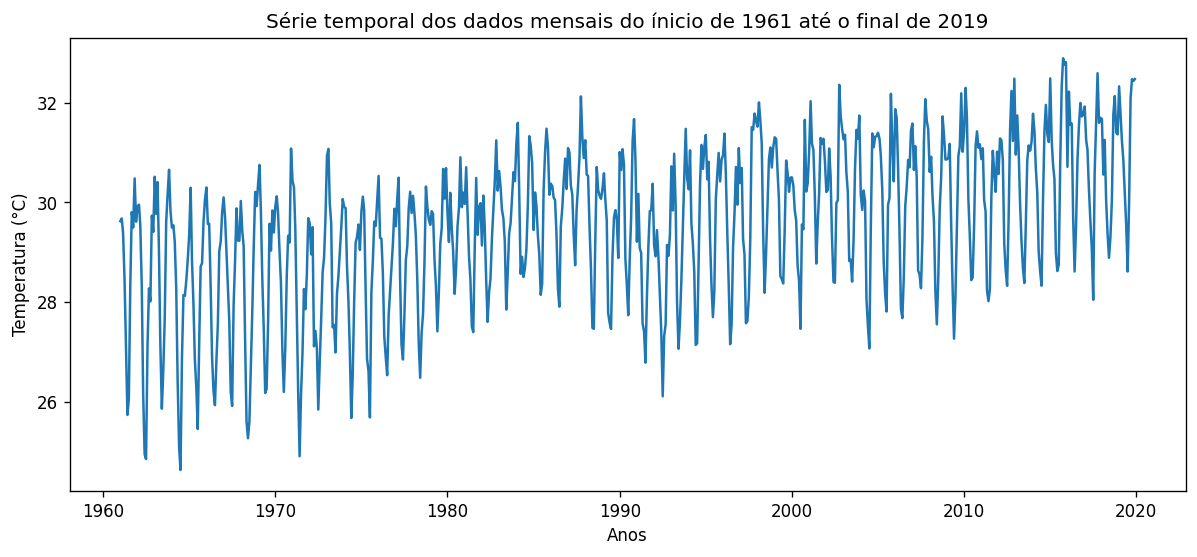

In [31]:
df = dfMes

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(df.index, df.TempMaxima)
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")
plt.title("Série temporal dos dados mensais do ínicio de 1961 até o final de 2019")
plt.savefig("serieMensal.png")

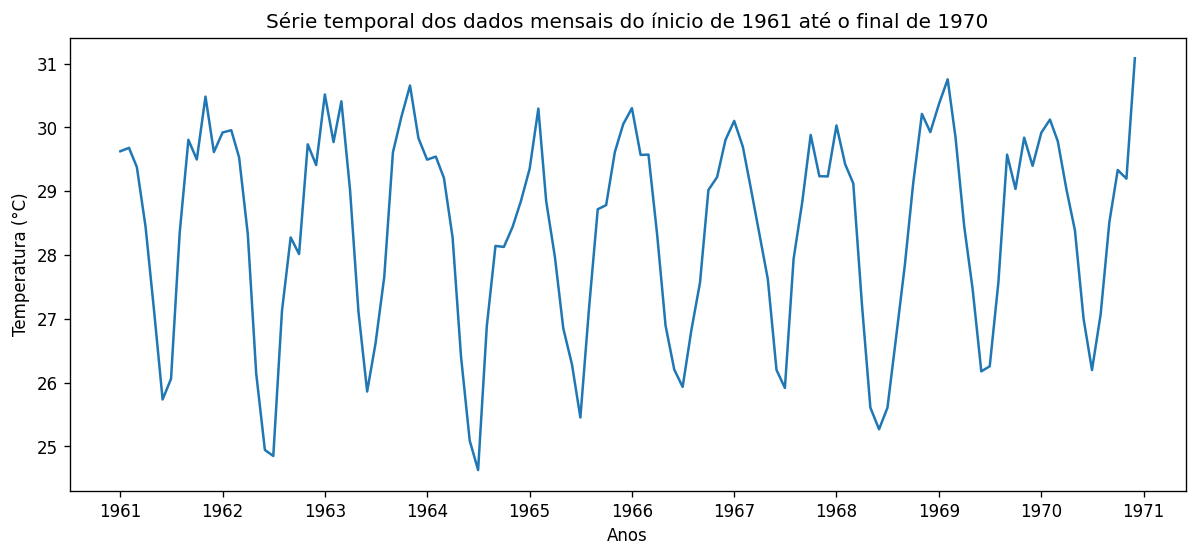

In [30]:
df = dfMes.loc['1961':'1970']

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(df.index, df.TempMaxima)
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")
plt.title("Série temporal dos dados mensais do ínicio de 1961 até o final de 1970")
plt.savefig("serieMensal19611970.png")

In [18]:
# TESTE PARA SERIE ESTACIONARIA
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.101085869006382
p-value: 0.2440781923564293
Critial Values:
   1%, -3.4398214107097225
Critial Values:
   5%, -2.8657196436385663
Critial Values:
   10%, -2.5689957624690525


/home/nadona/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


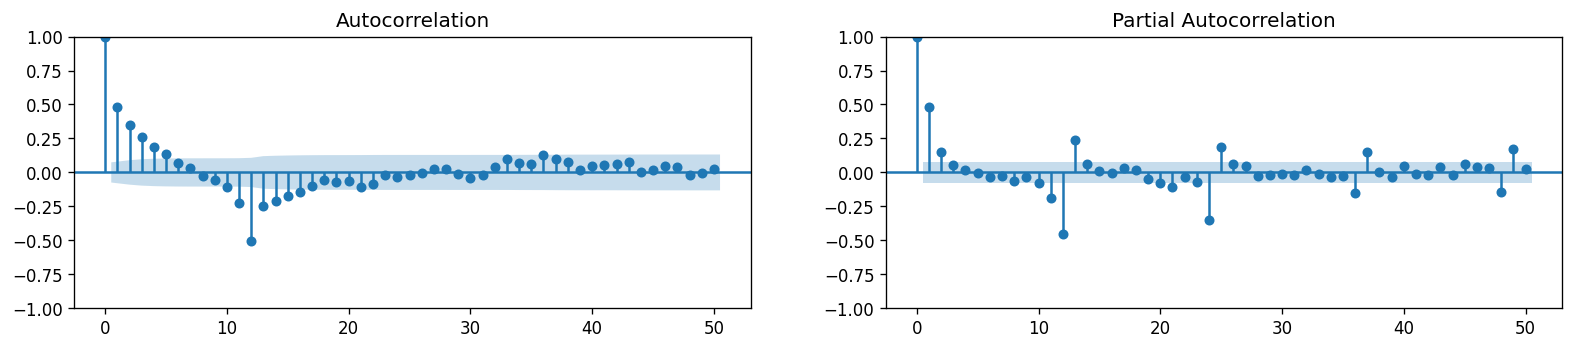

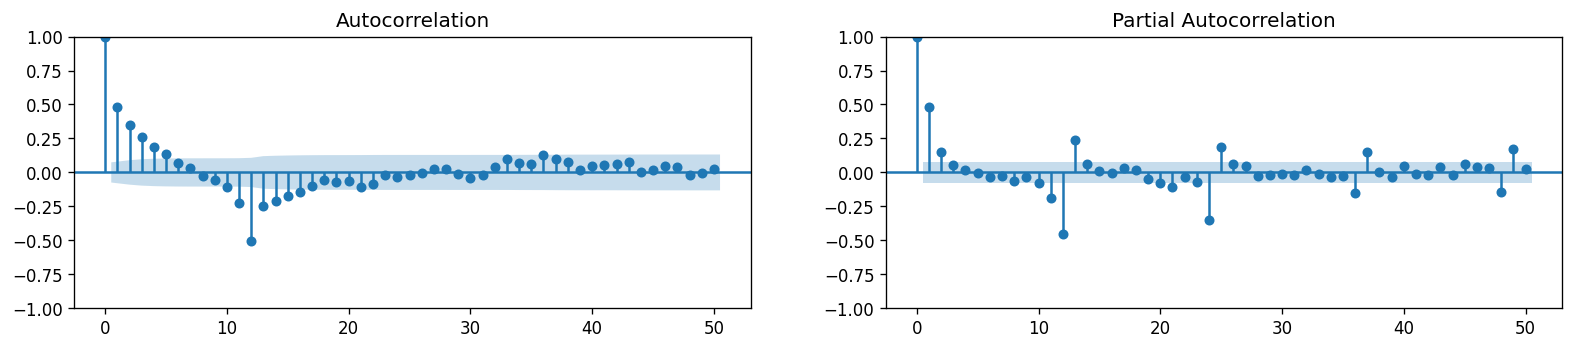

In [61]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 120)
plot_acf(df.diff(12).dropna(), lags=50, ax=axes[0])
plot_pacf(df.diff(12).dropna(), lags=50, ax=axes[1])

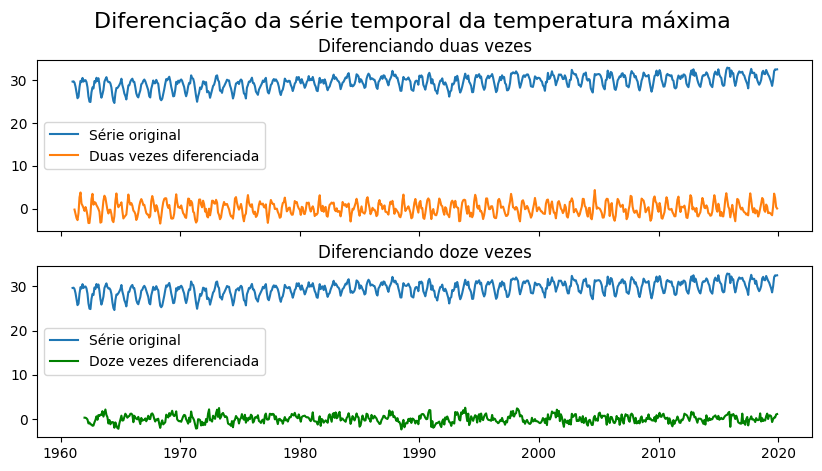

In [59]:
#APLICANDO SARIMA

fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Série original')
axes[0].plot(df[:].diff(2), label='Duas vezes diferenciada')
axes[0].set_title('Diferenciando duas vezes')
axes[0].legend(loc='center left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Série original')
axes[1].plot(df[:].diff(12), label='Doze vezes diferenciada', color='green')
axes[1].set_title('Diferenciando doze vezes')
plt.legend(loc='center left', fontsize=10)
plt.suptitle('Diferenciação da série temporal da temperatura máxima', fontsize=16)
plt.savefig("serieDiferenciacao.png")

Data
1961-01-01    29.624998
1961-02-01    29.678359
1961-03-01    29.377867
1961-04-01    28.446296
1961-05-01    27.148360
                ...    
2004-11-01    31.319462
2004-12-01    31.328336
2005-01-01    31.398887
2005-02-01    31.280191
2005-03-01    30.936391
Name: Maxima, Length: 531, dtype: float64

In [97]:
# Seasonal - fit stepwise auto-ARIMA

treino = df.Maxima[:int(3*len(df)/4)]
teste = df.Maxima[int(3*len(df)/4):]

modelo = pm.auto_arima(treino, start_p=0, start_q=0,
                         test='adf',
                         max_p=1, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

modelo.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1130.124, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1370.974, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1036.331, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=992.004, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1369.665, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1259.458, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=993.787, Time=1.42 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=993.819, Time=3.02 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1099.758, Time=0.57 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=995.705, Time=5.32 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=897.486, Time=1.65 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1193.202, Time=0.19 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=897.559, Time=1.98 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=897.694, Time=8.62 sec
 ARIMA(1,0,1)(1,1,0)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  531
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -443.743
Date:                            Wed, 30 Mar 2022   AIC                            897.486
Time:                                    02:07:50   BIC                            918.746
Sample:                                         0   HQIC                           905.815
                                            - 531                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0116      0.003      3.494      0.000       0.005       0.018
ar.L1          0.7601      0.045     16.932      0.000       0.672       0.848
ma.L1         -0.2580      0.067     -3.834      0.000      -0.390      -0.126
ma.S.L12      -0.8682      0.026    -32.944      0.000      -0.920      -0.817
sigma2         0.3131      0.020     15.551      0.000       0.274       0.353
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.95   Prob(JB):                         0.81
Heteroskedasticity (H):               1.16   Skew:                             0.04
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

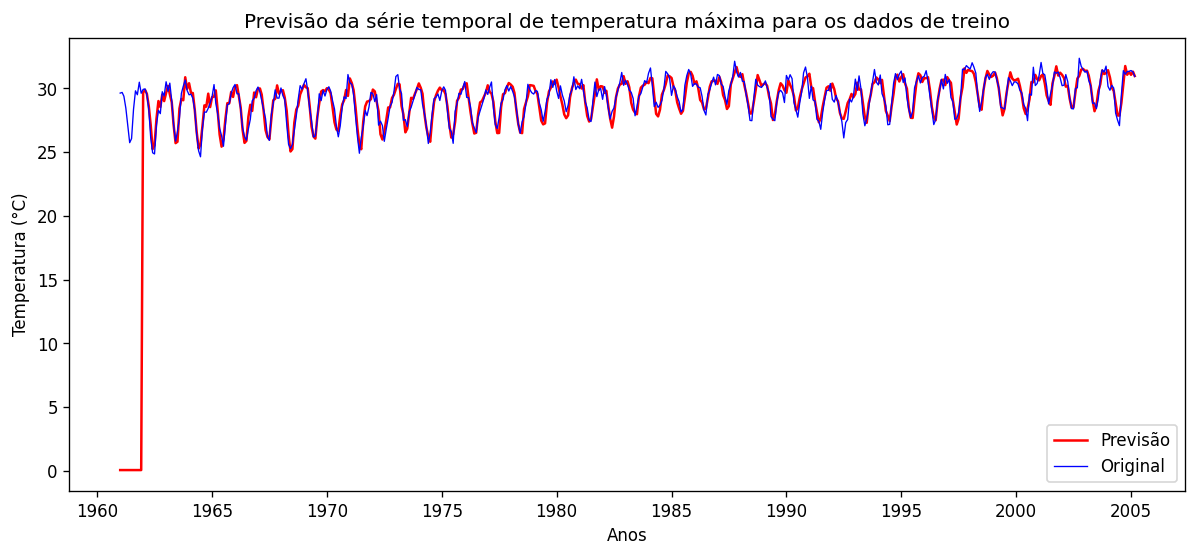

In [132]:
novo = pd.DataFrame(treino)
novo['Previsao'] = modelo.predict_in_sample()

# X = novo.loc['2000':'2010']
X = novo

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(X.index, X.Previsao, label='Previsão', color = 'red')
plt.plot(X.index, X.Maxima, label='Original', color = 'blue', linewidth = 0.8)
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão da série temporal de temperatura máxima para os dados de treino")
plt.legend()
plt.savefig("serieSARIMATreinoErrado.png")

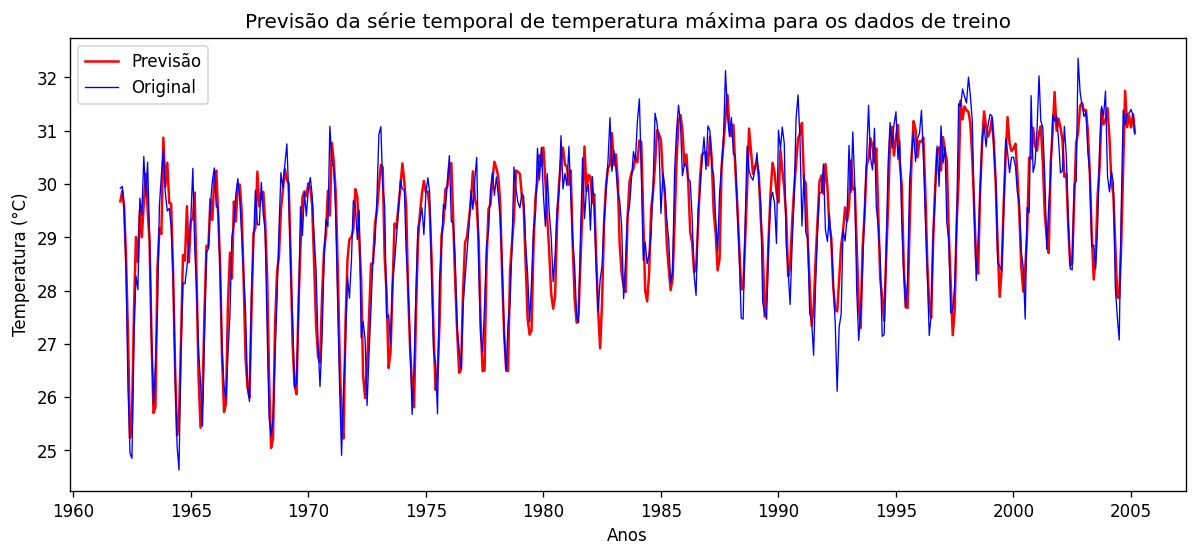

In [135]:
X = novo.loc['1962':'2010']

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(X.index, X.Previsao, label='Previsão', color = 'red')
plt.plot(X.index, X.Maxima, label='Original', color = 'blue', linewidth = 0.8)
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão da série temporal de temperatura máxima para os dados de treino")
plt.legend()
plt.savefig("serieSARIMATreinoCerto.png")

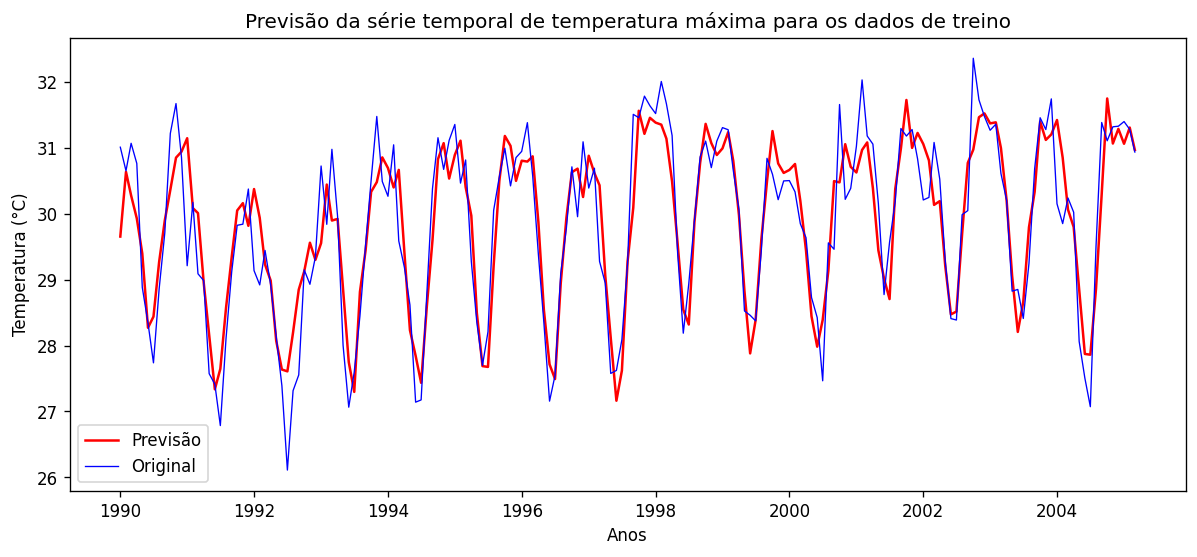

In [100]:
X = novo.loc['1990':'2019']

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(X.index, X.Previsao, label='Previsão', color = 'red')
plt.plot(X.index, X.Maxima, label='Original', color = 'blue', linewidth = 0.8)
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão da série temporal de temperatura máxima para os dados de treino")
plt.legend()
plt.savefig("serieSARIMATreino2000.png")

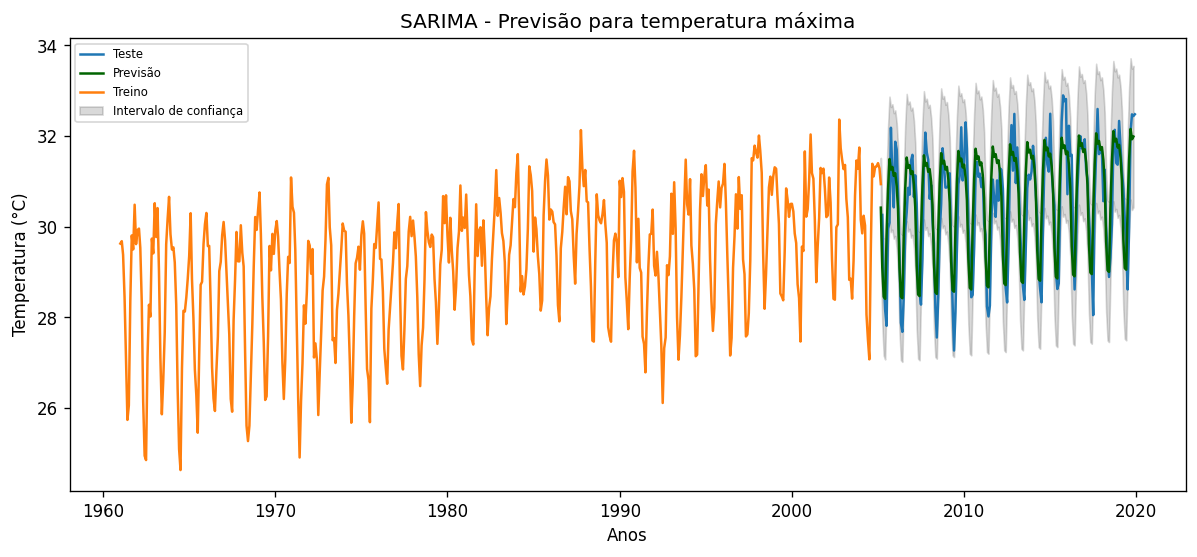

In [126]:
# Forecast
periodo = int(len(df)/4)
fit, intervaloConfianca = smodel.predict(n_periods=periodo, return_conf_int=True)
indice = pd.date_range(treino.index[-1], periods = periodo, freq='MS')

# make series for plotting purpose
fitSeries = pd.Series(fit, index=indice)
minimoSeries = pd.Series(intervaloConfianca[:, 0], index=indice)
maximoSeries = pd.Series(intervaloConfianca[:, 1], index=indice)

# Plot
plt.plot(teste, label='Teste')
plt.plot(fitSeries, color='darkgreen', label='Previsão')
plt.plot(treino, label='Treino')
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")
plt.fill_between(minimoSeries.index, 
                 minimoSeries, 
                 maximoSeries, 
                 color='k', alpha=.15, label='Intervalo de confiança')

plt.title("SARIMA - Previsão para temperatura máxima")
plt.legend(loc = "upper left", fontsize=7)
plt.savefig('serieSARIMAPrevisao.png')

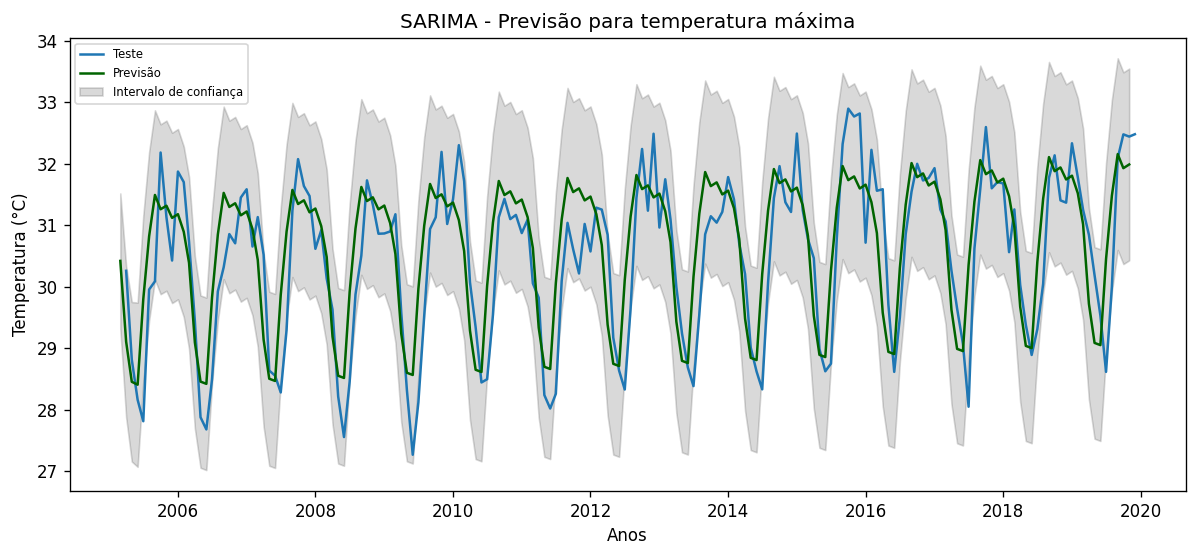

In [127]:
# Forecast
periodo = int(len(df)/4)
fit, intervaloConfianca = smodel.predict(n_periods=periodo, return_conf_int=True)
indice = pd.date_range(treino.index[-1], periods = periodo, freq='MS')

# make series for plotting purpose
fitSeries = pd.Series(fit, index=indice)
minimoSeries = pd.Series(intervaloConfianca[:, 0], index=indice)
maximoSeries = pd.Series(intervaloConfianca[:, 1], index=indice)

# Plot
plt.plot(teste, label='Teste')
plt.plot(fitSeries, color='darkgreen', label='Previsão')
plt.xlabel("Anos")
plt.ylabel("Temperatura (°C)")

plt.title("SARIMA - Previsão para temperatura máxima")
plt.legend(loc = "upper left", fontsize=7)
plt.savefig('serieSARIMAPrevisaoTeste.png')

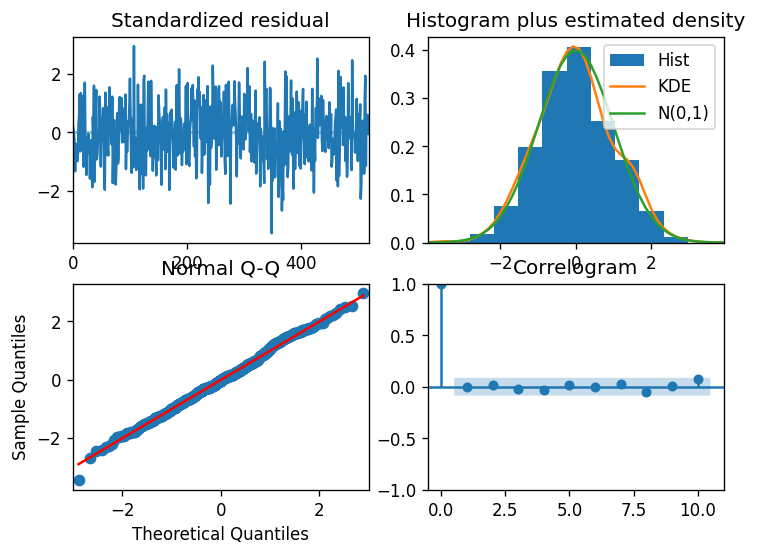

In [129]:
bla = modelo.plot_diagnostics(figsize=(7,5))

In [139]:
mean_squared_error(fit, teste)

0.2902273447365394

In [138]:
mean_squared_error(X.Previsao, treino.loc['1962':])

0.3216559092342198

In [ ]:
####APLICANDO EXPONENTIAL SMOOTHING

In [9]:
df = pd.DataFrame()
df['Data'] = dfMes.Data
df['Maxima'] = dfMes.TempMaxima
df = df.set_index('Data')

In [131]:
tamanhoTeste = int(3*len(df)/4)

treino = df.Maxima[:tamanhoTeste]
teste = df.Maxima[tamanhoTeste:]

periodo = 12
alfa = 0.6
beta = 0.01
gama = 0.05

###TRIPLE
modelo = ExponentialSmoothing(treino, trend='add', seasonal='add', seasonal_periods=periodo).fit(smoothing_level=alfa, smoothing_slope=beta, smoothing_seasonal=gama)
predicao = modelo.forecast(len(teste))

/home/nadona/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_12843/38804721.py:13: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  modelo = ExponentialSmoothing(treino, trend='add', seasonal='add', seasonal_periods=periodo).fit(smoothing_level=alfa, smoothing_slope=beta, smoothing_seasonal=gama)


In [116]:
modelo.params

{'smoothing_level': 0.6,
 'smoothing_trend': 0.01,
 'smoothing_seasonal': 0.05,
 'damping_trend': nan,
 'initial_level': 28.490883745893658,
 'initial_trend': 0.0008675125688581013,
 'initial_seasons': array([ 1.11091741,  1.18088318,  0.95573351,  0.03881431, -1.10871929,
        -1.98871201, -2.09734075, -0.80958025,  0.199883  ,  0.53382559,
         0.79396387,  0.82669885]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [132]:
mean_squared_error(treino, modelo.fittedvalues)

0.3512429803935157

In [133]:
mean_squared_error(teste, predicao)

0.32937942727192204

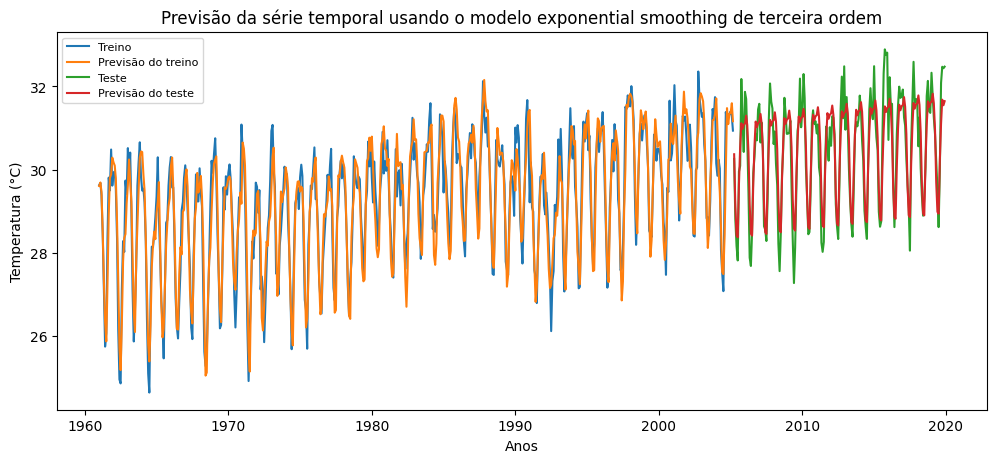

In [134]:
plt.figure(figsize=(12,5), dpi=100)
plt.xlabel('Anos')
plt.ylabel('Temperatura (°C)')
plt.plot(treino, label='Treino')
plt.plot(modelo.fittedvalues, label='Previsão do treino')
plt.plot(teste, label='Teste')
plt.plot(predicao, label='Previsão do teste')
plt.title('Previsão da série temporal usando o modelo exponential smoothing de terceira ordem')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('exponential.png')

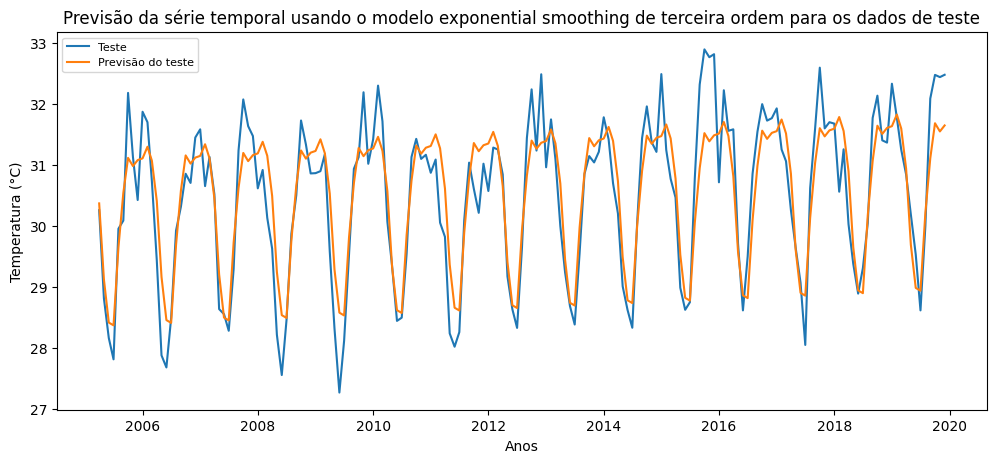

In [135]:
plt.figure(figsize=(12,5), dpi=100)
plt.xlabel('Anos')
plt.ylabel('Temperatura (°C)')
plt.plot(teste, label='Teste')
plt.plot(predicao, label='Previsão do teste')
plt.title('Previsão da série temporal usando o modelo exponential smoothing de terceira ordem para os dados de teste')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('exponentialTeste.png')
plt.show()

In [211]:
###########LSTM USANDO PYTORCH###########

tamanhoTreino = int(3*len(df)/4)

treino = df.Maxima[:tamanhoTreino]
teste = df.Maxima[tamanhoTreino:]

In [213]:
scaler = MinMaxScaler(feature_range=(-1, 1))
treinoNormalizado = scaler.fit_transform(treino.iloc[:].values.reshape(-1, 1))

In [214]:
treinoNormalizado = torch.FloatTensor(treinoNormalizado).view(-1)

In [158]:
def criar_sequencia(dado, periodo):
    sequencia = []
    comprimento = len(dado)
    
    for i in range(comprimento-periodo):
        sequenciaTreino = dado[i:i+periodo]
        indiceTreino = dado[i+periodo:i+periodo+1]
        sequencia.append((sequenciaTreino ,indiceTreino))
    
    return sequencia

In [159]:
periodo = 12
sequenciaTreino = criar_sequencia(treinoNormalizado, periodo)

In [144]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [166]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [167]:
epochs = 150

for i in range(epochs):
    for seq, labels in sequenciaTreino:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01140043
epoch:  26 loss: 0.00041213
epoch:  51 loss: 0.00026210
epoch:  76 loss: 0.00095228
epoch: 101 loss: 0.00037700
epoch: 126 loss: 0.00185588
epoch: 149 loss: 0.0003542772


In [171]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [168]:
fut_pred = 107

test_inputs = treinoNormalizado[-periodo:].tolist()

In [169]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-periodo:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [164]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[periodo:] ).reshape(-1, 1))
# x = np.arange(2, 708, 1)

array([[31.3041436 ],
       [31.47508267],
       [31.35145122],
       [30.91354004],
       [30.13127927],
       [29.12126714],
       [28.28363075],
       [27.94336435],
       [28.20713645],
       [28.53482913],
       [28.65882919],
       [28.50903072],
       [28.24712379],
       [28.20196926],
       [28.62684122],
       [29.55902224],
       [30.73948619],
       [31.47596965],
       [31.56434569],
       [31.51365605],
       [31.50083665],
       [31.52708135],
       [31.47907889],
       [31.23976141],
       [30.70369445],
       [29.83910667],
       [28.8927878 ],
       [28.19542992],
       [28.02797203],
       [28.28543522],
       [28.51622668],
       [28.56237396],
       [28.38735147],
       [28.1972914 ],
       [28.28477748],
       [28.84778325],
       [29.86991421],
       [30.99861424],
       [31.53403244],
       [31.55768211],
       [31.51104674],
       [31.5101054 ],
       [31.52781811],
       [31.44304986],
       [31.14560277],
       [30

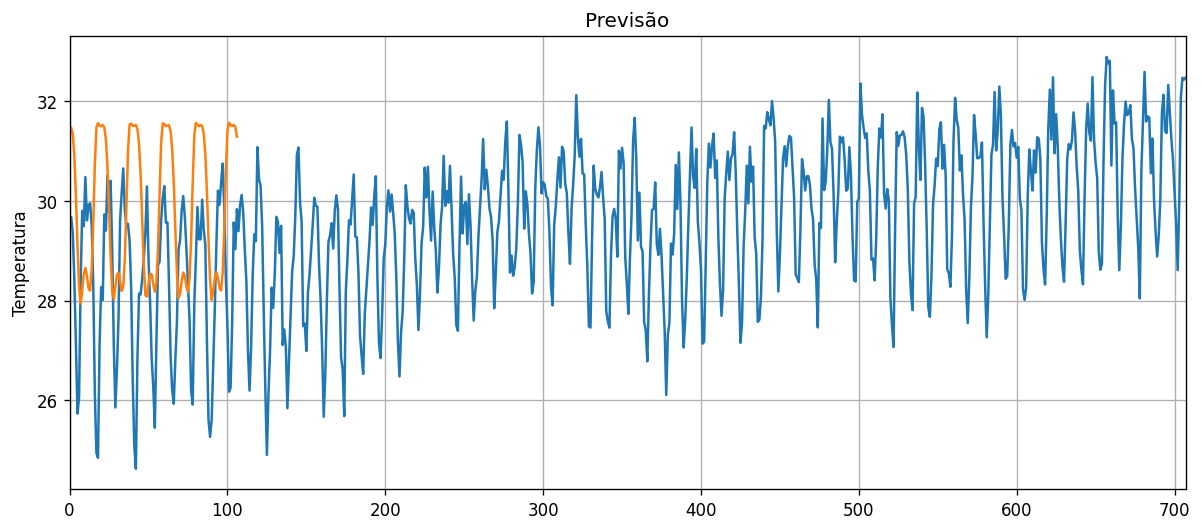

In [170]:
plt.title('Previsão')
plt.ylabel('Temperatura')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df.Maxima.values)
plt.plot(actual_predictions)
plt.show()

In [ ]:
###########LSTM USANDO KERA ###########

In [198]:
tamanhoTreino = int(3*len(df)/4)

escala = MinMaxScaler(feature_range=(0, 1))
dadosNormalizados = escala.fit_transform(df.Maxima.iloc[:].values.reshape(-1, 1))

treino = dadosNormalizados[:tamanhoTreino]
teste = dadosNormalizados[tamanhoTreino:]

In [199]:
def ajustaDados(dataset):
    dadosX, dadosY = [],[]
    
    for i in range(len(dataset) - 2):
        a = dataset[i:(i + 1),0]
        dadosX.append(a)
        dadosY.append(dataset[i + 1,0])
    
    return np.array(dadosX), np.array(dadosY)

In [200]:
treinoX, treinoY = ajustaDados(treino)
testeX, testeY = ajustaDados(teste)

In [201]:
treinoX = np.reshape(treinoX, (treinoX.shape[0], 1, treinoX.shape[1]))
testeX = np.reshape(testeX, (testeX.shape[0], 1, testeX.shape[1]))

In [202]:
model = keras.Sequential()
model.add(layers.LSTM(4))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(treinoX, treinoY, epochs=20, batch_size=1)

Epoch 1/20
529/529 [==============================] - 2s 2ms/step - loss: 0.0803
Epoch 2/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 3/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 4/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 5/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 6/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0118
Epoch 7/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0117
Epoch 8/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 9/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0117
Epoch 10/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 11/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 12/20
529/529 [==============================] - 1s 2ms/step - loss: 0.0114
Epoch 13/20
529/529 [====

In [203]:
treinoPredicao = escala.inverse_transform(model.predict(treinoX))
treinoY = escala.inverse_transform([treinoY])
testePredicao = escala.inverse_transform(model.predict(testeX))
testeY = escala.inverse_transform([testeY])

In [204]:
mean_squared_error(treinoY[0],treinoPredicao[:,0])

0.7833160845087993

In [205]:
mean_squared_error(testeY[0],testePredicao[:,0])

0.8423739815836084

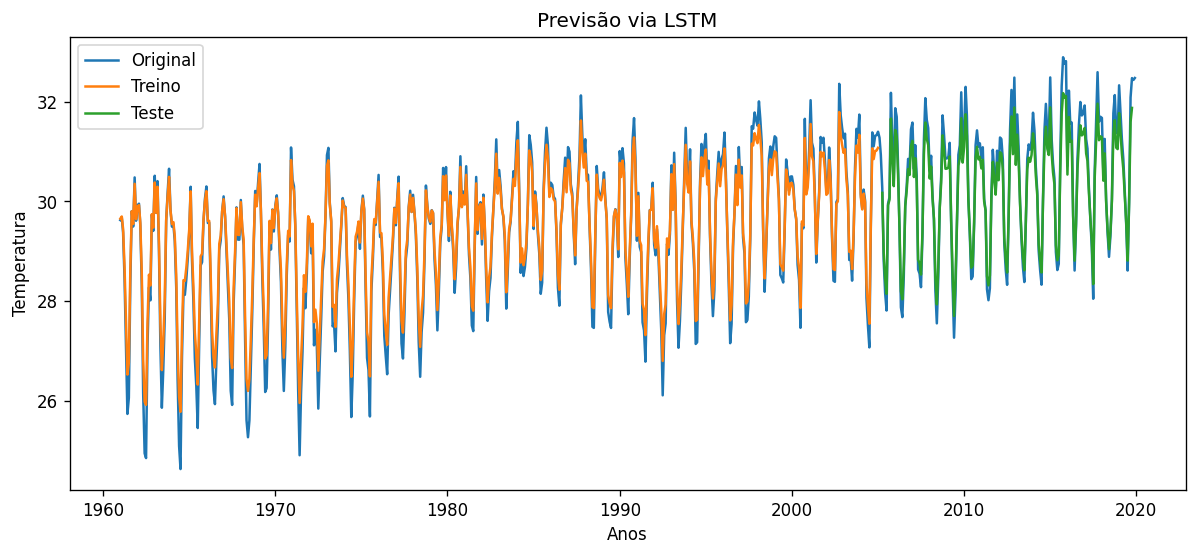

In [206]:
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(df.index, df.Maxima.values, label='Original')
plt.plot(df.index[:int(3*len(df)/4 - 2)], treinoPredicao, label='Treino')
plt.plot(df.index[int(3*len(df)/4):len(df)-2],testePredicao, label='Teste')
plt.title('Previsão via LSTM')
plt.xlabel('Anos')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('previsaoLSTM.png')

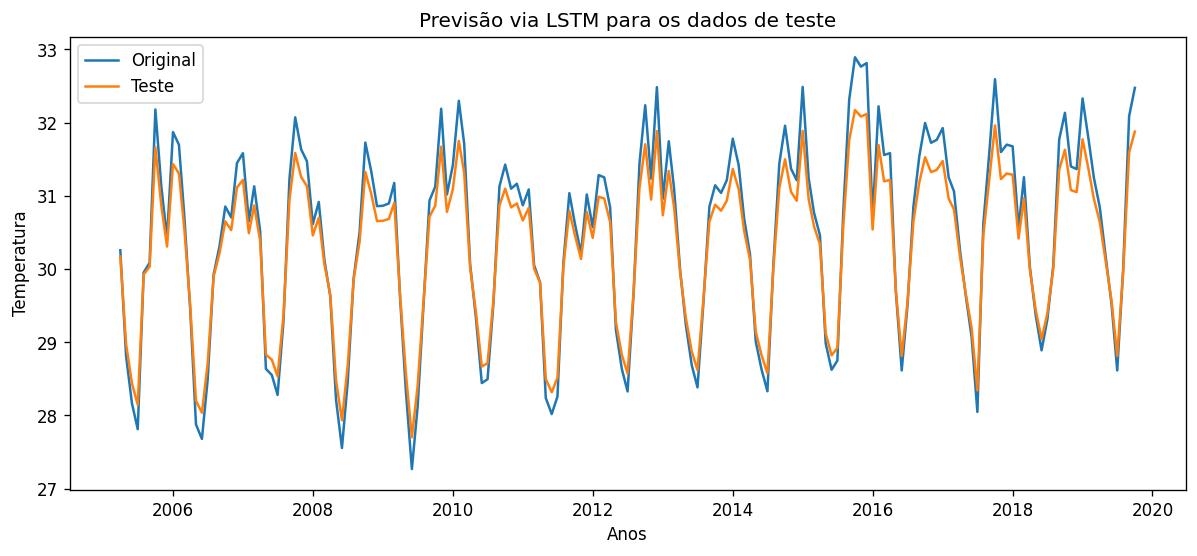

In [207]:
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(df.index[int(3*len(df)/4):len(df)-2], df.Maxima.values[int(3*len(df)/4):len(df)-2], label='Original')
plt.plot(df.index[int(3*len(df)/4):len(df)-2],testePredicao, label='Teste')
plt.title('Previsão via LSTM para os dados de teste')
plt.xlabel('Anos')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('previsaoLSTMTeste.png')

In [196]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 4)                 272       
                                                                 
 dense_22 (Dense)            (None, 1)                 5         
                                                                 
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [22]:
for ano in range(1961, 1999):
    dadosPlot.Data = dadosPlot.Data.transform(lambda x: str(ano) if str(x).startswith(str(ano)) else x)

NameError: name 'dadosPlot' is not defined

<AxesSubplot:xlabel='Data', ylabel='Precipitacao'>

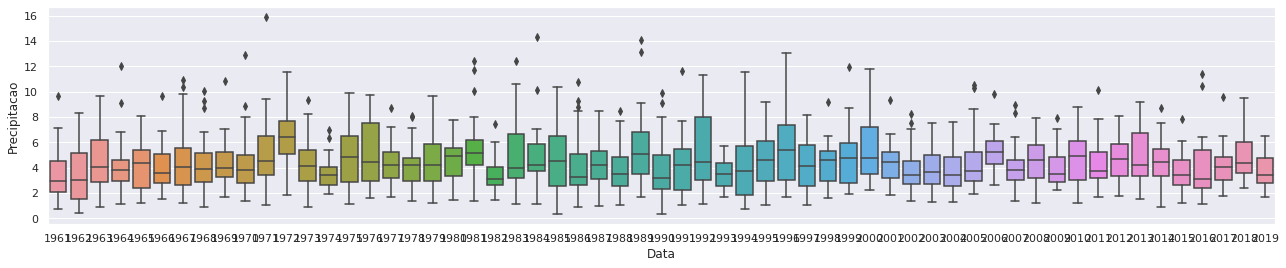

In [47]:
sns.set(rc={"figure.figsize":(22, 4)}) #width=8, height=4
sns.boxplot(x="Data", y="Precipitacao", data=dadosPlot)

In [215]:
######FUNCOES PARA CRIAR PASTAS######

In [33]:
def defineMes(mes):
    if(mes == 1):
        return "janeiro"
    elif(mes == 2):
        return "fevereiro"
    elif(mes == 3):
        return "marco"
    elif(mes == 4):
        return "abril"
    elif(mes == 5):
        return "maio"
    elif(mes == 6):
        return "junho"
    elif(mes == 7):
        return "julho"
    elif(mes == 8):
        return "agosto"
    elif(mes == 9):
        return "setembro"
    elif(mes == 10):
        return "outubro"
    elif(mes == 11):
        return "novembro"
    elif(mes == 12):
        return "dezembro"

def criaDiretorio(diretorioPai, nome):   
    path = os.path.join(diretorioPai, nome)
    os.makedirs(path)

In [ ]:
######CRIA GRAFICOS MENSAIS PARA CADA ESTADOS######

In [327]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']
for sigla in estados:
    planilhaEstado = planilha[planilha.Nome.str.contains('- ' + sigla)]
    planilhaEstado['Data'] = pd.to_datetime(planilhaEstado['Data'], format='%d/%m/%Y')
    
    dfmaxima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfminima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfprecipitacao = pd.DataFrame({'Ano': [],
                                   1: [], 
                                   2: [], 
                                   3: [], 
                                   4: [], 
                                   5: [], 
                                   6: [], 
                                   7: [], 
                                   8: [], 
                                   9: [], 
                                   10: [], 
                                   11: [], 
                                   12: []})


    for ano in range(1961, 2020, 1):
        dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(ano)]
        dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
        dftranspose = dfano.transpose()
        dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
        dfmaxima.Ano.mask(dfmaxima.index == ano - 1961, str(ano), inplace=True)
        dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
        dfminima.Ano.mask(dfminima.index == ano - 1961, str(ano), inplace=True)
        dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
        dfprecipitacao.Ano.mask(dfprecipitacao.index == ano - 1961, str(ano), inplace=True)
        
    dfmaxima.dropna(thresh=2, inplace = True)
    dfminima.dropna(thresh=2, inplace = True)
    dfprecipitacao.dropna(thresh=2, inplace = True)
    
    
    criaDiretorio("/home/fnadona/graficos", sigla)
    pasta = os.path.join("/home/fnadona/graficos", sigla)
    
    for i in range(1,13,1):
        dfmaxima.update(dfmaxima[i].fillna(dfmaxima[i].mean()))
        
        y = dfmaxima.iloc[:,i].values.reshape(-1, 1)  #dependent variable vector
        X = np.array(range(int(dfmaxima.iloc[0,0]), int(dfmaxima.iloc[0,0]) + len(dfmaxima))).reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        score = regressor.score(X_test, y_test)
        
        while(score < 0.0):
            y = dfmaxima.iloc[:,i].values.reshape(-1, 1)  #dependent variable vector
            X = np.array(range(int(dfmaxima.iloc[0,0]), int(dfmaxima.iloc[0,0]) + len(dfmaxima))).reshape(-1, 1)
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
            regressor = LinearRegression()
            regressor.fit(X_train, y_train)
            score = regressor.score(X_test, y_test)
        
        mes = defineMes(i)
        criaDiretorio(pasta, mes)
        caminhoPasta = os.path.join(pasta, mes)
        figura = os.path.join(caminhoPasta, mes + ".pdf")
    
        fig = plt.figure(i)
        plt.scatter(X_train, y_train, color='red') # plotting the observation line
        plt.title('Temperatura no mes de ' + mes)
        plt.xlabel('Anos', fontsize=15)
        plt.ylabel('Temperatura (Celsius)', fontsize=15)
        plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
        plt.legend()
        fig.savefig(figura, format='pdf')
        fig.clear(True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
######CRIA TABELAS DE MEDIAS ANUAIS PARA CADA ESTADO######

In [5]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']

dfBrasilMax = pd.DataFrame()
dfBrasilMin = pd.DataFrame()
dfBrasilPrecipitacao = pd.DataFrame()

dfBrasilMax['Ano'] = dfmaxima['Ano']
dfBrasilMin['Ano'] = dfminima['Ano']
dfBrasilPrecipitacao['Ano'] = dfprecipitacao['Ano']

for sigla in estados:
    planilhaEstado = planilha[planilha.Nome.str.contains('- ' + sigla)]
    planilhaEstado['Data'] = pd.to_datetime(planilhaEstado['Data'], format='%d/%m/%Y')
    
    dfmaxima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfminima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfprecipitacao = pd.DataFrame({'Ano': [],
                                   1: [], 
                                   2: [], 
                                   3: [], 
                                   4: [], 
                                   5: [], 
                                   6: [], 
                                   7: [], 
                                   8: [], 
                                   9: [], 
                                   10: [], 
                                   11: [], 
                                   12: []})

    for ano in range(1961, 2020, 1):
        dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(ano)]
        dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
        dftranspose = dfano.transpose()
        dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
        dfmaxima.Ano.mask(dfmaxima.index == ano - 1961, str(ano), inplace=True)
        dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
        dfminima.Ano.mask(dfminima.index == ano - 1961, str(ano), inplace=True)
        dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
        dfprecipitacao.Ano.mask(dfprecipitacao.index == ano - 1961, str(ano), inplace=True)
        
    dfmaxima.dropna(thresh=2, inplace = True)
    dfminima.dropna(thresh=2, inplace = True)
    dfprecipitacao.dropna(thresh=2, inplace = True)
    
    for i in range(1,13,1):
        dfmaxima.update(dfmaxima[i].fillna(dfmaxima[i].mean()))
        dfminima.update(dfminima[i].fillna(dfminima[i].mean()))
        dfprecipitacao.update(dfprecipitacao[i].fillna(dfprecipitacao[i].mean()))
        
    dfBrasilMax[sigla] = dfmaxima.drop(columns=['Ano'], axis=1).mean(axis=1)
    dfBrasilMin[sigla] = dfminima.drop(columns=['Ano'], axis=1).mean(axis=1)
    dfBrasilPrecipitacao[sigla] = dfprecipitacao.drop(columns=['Ano'], axis=1).mean(axis=1)

In [ ]:
######CRIA GRAFICOS DA MEDIAS ANUAIS PARA CADA ESTADO######

In [76]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']
criaDiretorio("/home/fnadona/graficos", "chuva")
pasta = os.path.join("/home/fnadona/graficos", "chuva")
k=1
for sigla in estados:
    dfGraficos = dfBrasilPrecipitacao[['Ano', sigla]].dropna()
    dfGraficos['Ano'] = dfGraficos.Ano.transform(lambda x: float(x))
    dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
        
    y = dfGraficos.iloc[:,1].values.reshape(-1, 1)  #dependent variable vector
    X = dfGraficos.iloc[:,0].values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
        
#     while(score < 0.0):
#         y = dfmaxima.iloc[:,i].values.reshape(-1, 1)  #dependent variable vector
#         X = np.array(range(int(dfmaxima.iloc[0,0]), int(dfmaxima.iloc[0,0]) + len(dfmaxima))).reshape(-1, 1)
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
#         regressor = LinearRegression()
#         regressor.fit(X_train, y_train)
#         score = regressor.score(X_test, y_test)
        
#     mes = defineMes(i)
    figura = os.path.join(pasta, sigla + ".pdf")
    
    fig = plt.figure(k)
    plt.scatter(X_train, y_train, color='red') # plotting the observation line
    plt.title('Temperatura no estado ' + sigla)
    plt.xlabel('Anos', fontsize=15)
    plt.ylabel('Temperatura (Celsius)', fontsize=15)
    plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
    plt.legend()
    fig.savefig(figura, format='pdf')
    fig.clear(True)
    k = k+1

# dfGraficos =dfBrasilMax[['Ano', 'RR']].dropna()
# dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
# dfGraficos

<ipython-input-76-e6c6dd99975f>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(k)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
######CRIA GRAFICO DE MEDIA ANUAL PARA O BRASIL######

In [91]:
criaDiretorio("/home/fnadona/graficos", "chuvaBrasil")
pasta = os.path.join("/home/fnadona/graficos", "chuvaBrasil")

dfGraficos = pd.DataFrame()

dfGraficos['Media'] = dfBrasilPrecipitacao.drop(columns=['Ano'], axis=1).mean(axis=1)
dfGraficos['Ano'] = dfBrasilPrecipitacao.Ano.transform(lambda x: float(x))
dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
        
y = dfGraficos.iloc[:,0].values.reshape(-1, 1)  #dependent variable vector
X = dfGraficos.iloc[:,1].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
        
while(score < 0.1):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
        
figura = os.path.join(pasta, "Brasil.pdf")
    
fig = plt.figure()
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.title('Temperatura no Brasil')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura (Celsius)', fontsize=15)
plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
plt.legend()
fig.savefig(figura, format='pdf')
fig.clear(True)

<Figure size 432x288 with 0 Axes>

In [10]:
dados.head()

Estacao        Data  Precipitacao  TempMaxima  TempMinima  Temp Comp Media
0    82024  01/01/1961           NaN        32.3         NaN            26.56
1    82024  01/01/1961           NaN         NaN        22.9              NaN
2    82024  01/01/1961           NaN         NaN         NaN              NaN
3    82024  02/01/1961           NaN        33.2         NaN            28.06
4    82024  02/01/1961          16.0         NaN        23.7              NaN

In [2]:
exemploEstacao = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/weather_stations_codes.csv'
                      , sep=";")
exemploDados = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/conventional_weather_stations_inmet_brazil_1961_2019.csv'
                      , sep=";")

In [11]:
exemploEstacao.dtypes

Nome                   object
Código                  int64
Latitude              float64
Longitude             float64
Altitude              float64
Status da Operação     object
Ínicio da Operação     object
dtype: object

In [21]:

        
# csvFile = dffinal.to_csv('tabelaTeste.csv', date_format='%d/%m/%Y', index=True)

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

In [22]:
dffinal

Precipitacao  TempMaxima  TempMinima  Temp Comp Media          Nome  \
Codigo                                                                        
82294            0.0        29.1        22.6            24.84   ACARAU - CE   
82294            0.6        28.6        23.2            24.88   ACARAU - CE   
82294            2.6        29.8        21.8            25.64   ACARAU - CE   
82294           22.1        29.4        19.6            24.76   ACARAU - CE   
82294           12.5        29.0        22.2            24.88   ACARAU - CE   
...              ...         ...         ...              ...           ...   
82376            0.0        34.9        23.4            28.00  ZE DOCA - MA   
82376            0.0        35.5        24.0            29.14  ZE DOCA - MA   
82376            0.5        31.3        24.6            27.28  ZE DOCA - MA   
82376            8.5        30.9        23.5            25.98  ZE DOCA - MA   
82376           44.2        28.1        21.4            24.80  ZE DOCA - MA   

             Data  
Codigo             
82294  1976-03-04  
82294  1976-03-05  
82294  1976-03-06  
82294  1976-03-07  
82294  1976-03-08  
...           ...  
82376  2019-12-27  
82376  2019-12-28  
82376  2019-12-29  
82376  2019-12-30  
82376  2019-12-31  

[3697349 rows x 6 columns]

In [ ]:
######CRIA TABELA PRINCIPAL######

In [21]:
estados = ['AP', 'AM', 'RO', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']
dffinal = pd.DataFrame()

for station in estados:
    estacao = estacaoplanilha[estacaoplanilha.Nome.str.contains('- ' + station)]
    for codigo in estacao['Código']:
        dfdados = dados[dados.Estacao == codigo]
        dfjoin = dfdados.set_index("Estacao").join(estacao.set_index("Código"))
        dfjoin.Data = pd.to_datetime(dfjoin.Data, format='%d/%m/%Y')
        dfagrupado = dfjoin.groupby('Data').max()
        dfagrupado.Precipitacao = dfagrupado.Precipitacao.transform(lambda x: 0.0 if m.isnan(x) else x)
        dfagrupado = dfagrupado.dropna()
        dfagrupado['Data'] = dfagrupado.index
        dfagrupado['Codigo'] = dfagrupado.Nome.transform(lambda x: estacao.loc[estacao.Nome == x, 'Código'].values[0])
        dfagrupado = dfagrupado.set_index('Codigo')
        dffinal = dffinal.append(dfagrupado, ignore_index=False)
        
csvFile = dffinal.to_csv('tabelaTeste.csv', date_format='%d/%m/%Y', index=True)

Precipitacao  TempMaxima  TempMinima  Temp Comp Media           Nome  \
Codigo                                                                         
82098            0.0        32.4        20.4            27.40    MACAPA - AP   
82098            0.0        32.4        20.4            27.20    MACAPA - AP   
82098            0.0        32.4        20.4            26.72    MACAPA - AP   
82098            0.0        32.4        20.4            26.92    MACAPA - AP   
82098            0.0        33.2        22.2            27.68    MACAPA - AP   
...              ...         ...         ...              ...            ...   
83373            0.0        29.0        12.8            20.88  RONCADOR - DF   
83373            0.0        29.8        18.4            22.10  RONCADOR - DF   
83373            0.0        27.4        15.4            20.64  RONCADOR - DF   
83373            0.0        23.4        14.6            18.84  RONCADOR - DF   
83373            0.0        30.2        10.6            20.98  RONCADOR - DF   

             Data  
Codigo             
82098  1967-12-01  
82098  1967-12-02  
82098  1967-12-03  
82098  1967-12-04  
82098  1967-12-05  
...           ...  
83373  2017-09-14  
83373  2017-09-18  
83373  2017-09-21  
83373  2017-09-22  
83373  2017-09-26  

[3697349 rows x 6 columns]

In [23]:
dffinal.isnull().sum()

Precipitacao       0
TempMaxima         0
TempMinima         0
Temp Comp Media    0
Nome               0
Data               0
dtype: int64

In [ ]:
######CRIA GRAFICOS DE BARRAS PARA CADA MES DE UM ESTACAO######

<ipython-input-30-f4e1e3e94f5b>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(12,1,mes)


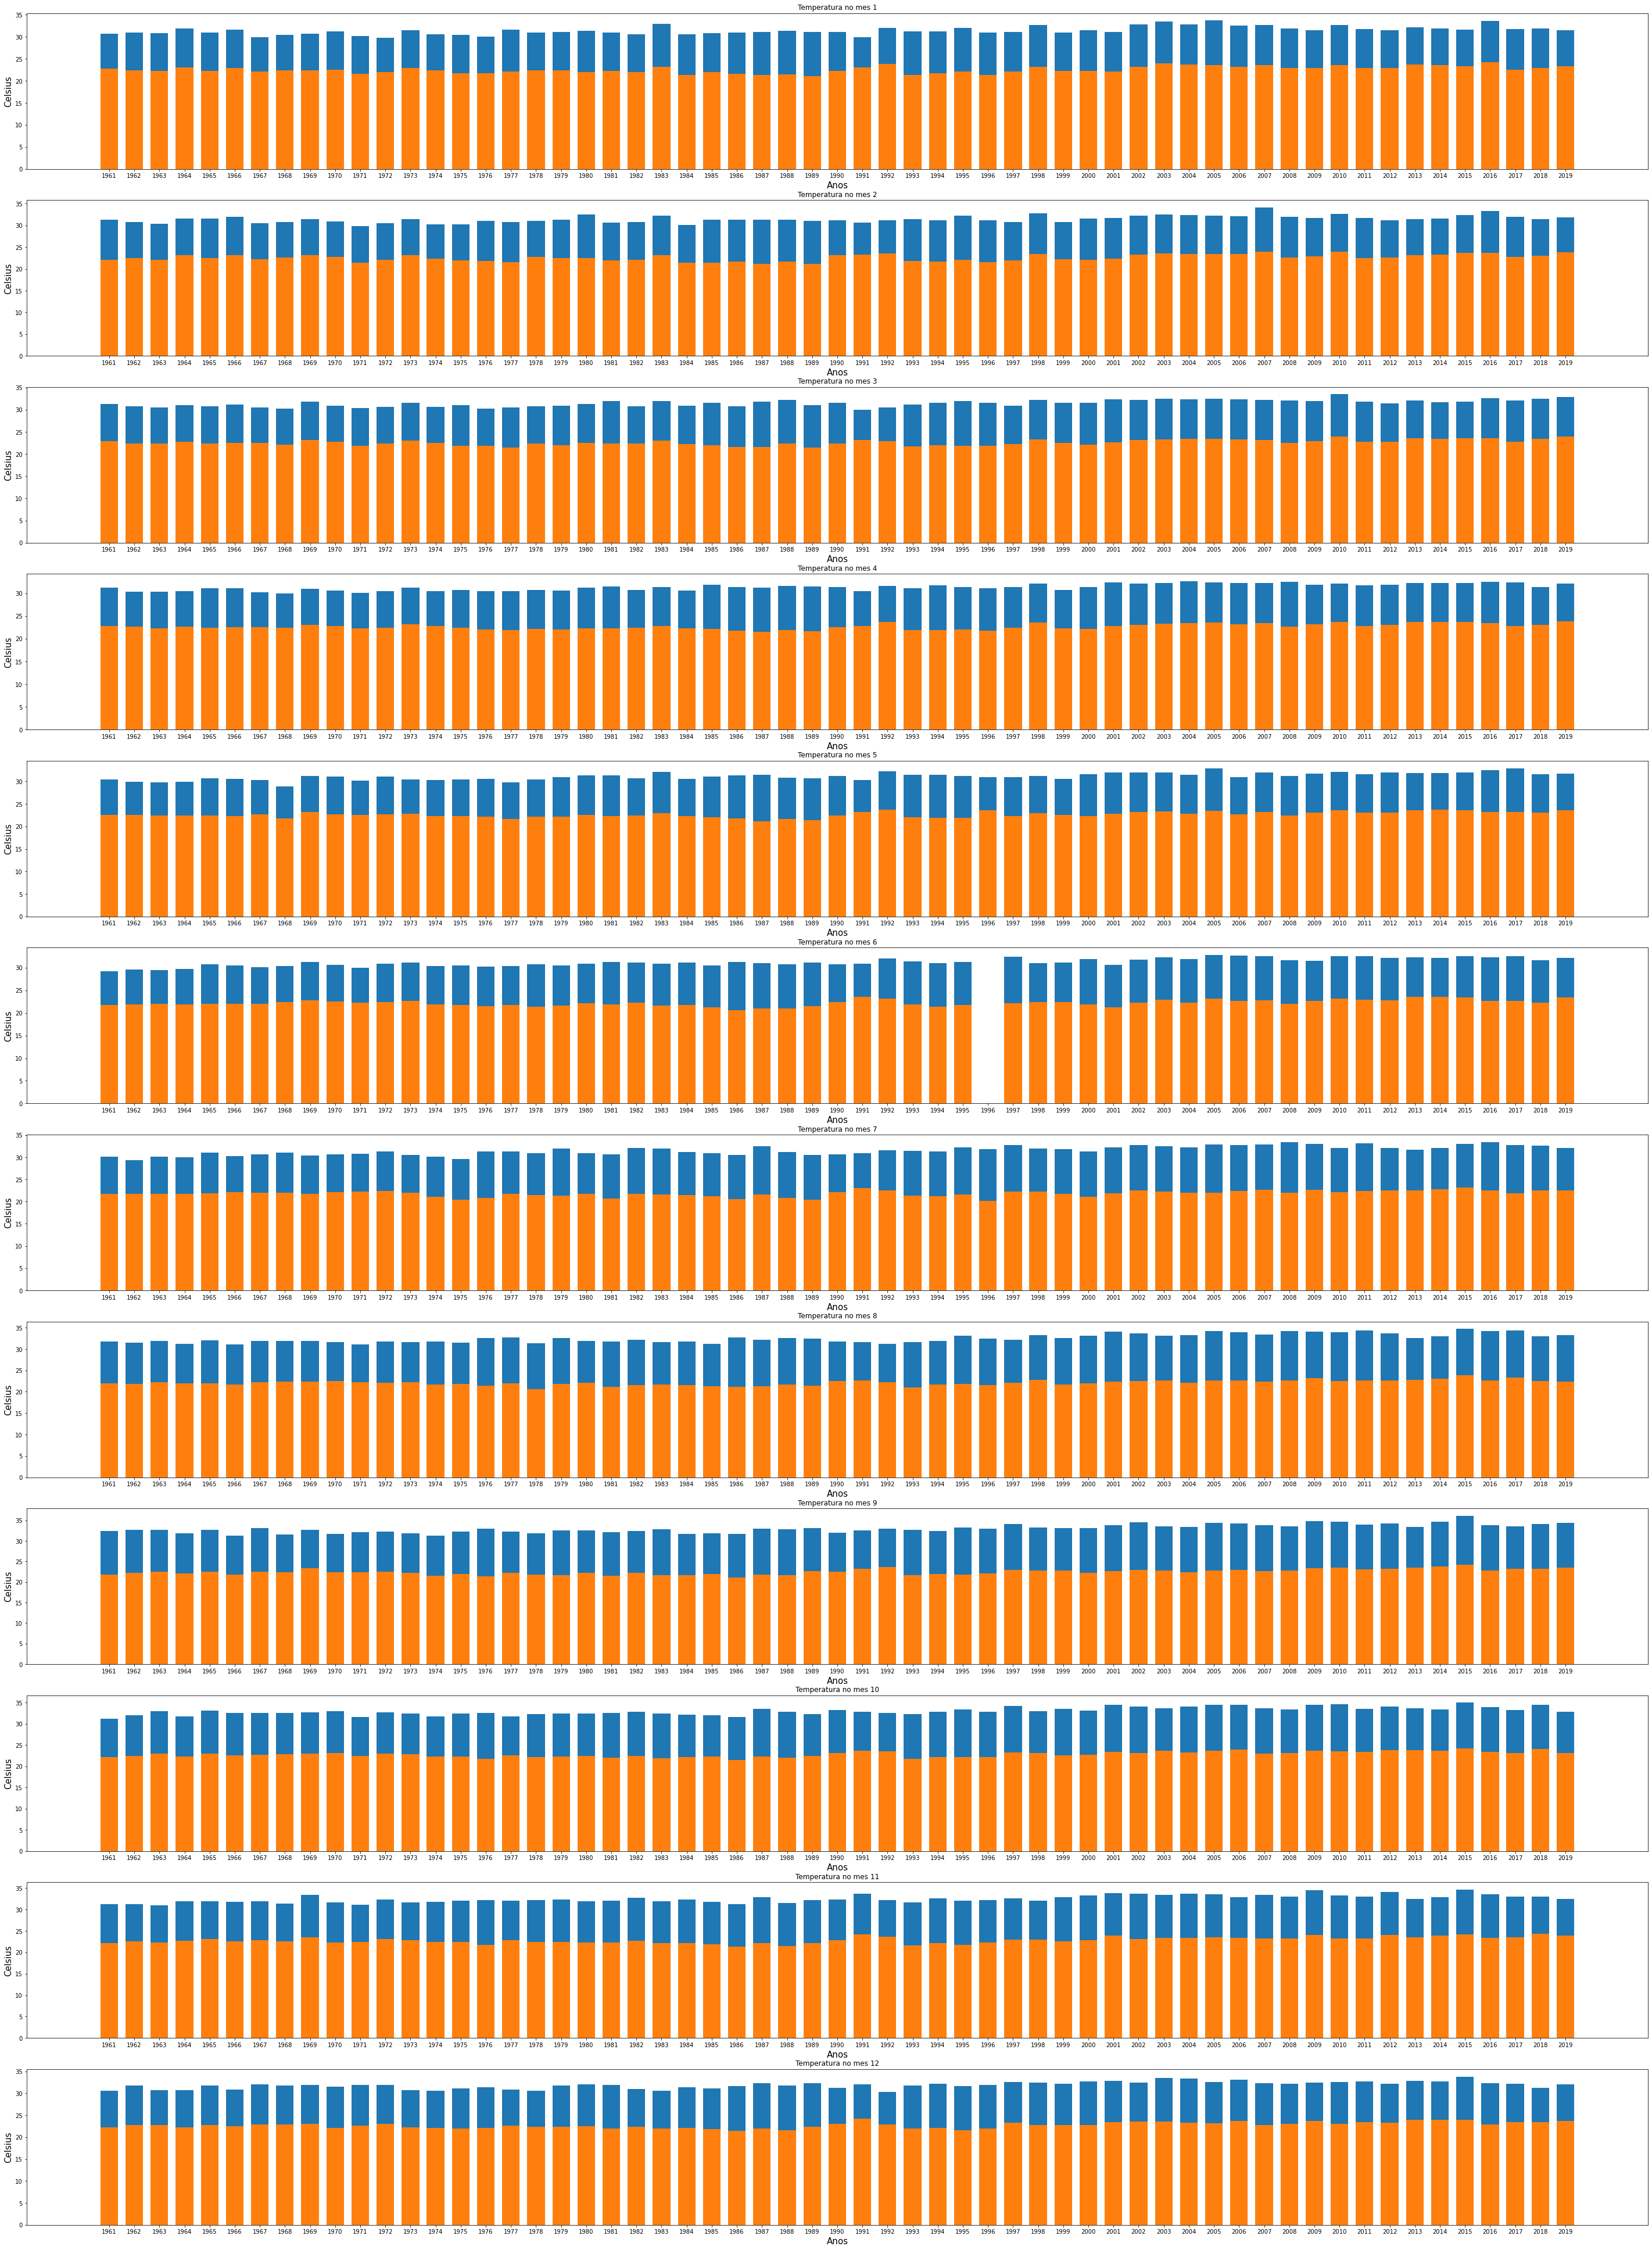

In [30]:
plt.figure(figsize=(50,70))

#FAZER O PLOT DA TEMPERATURA MAXIMA EM CADA MES POR ANO
# dfteste = dfmaxima.transpose()
# for ano in range(1961, 1979, 1):
#     plt.subplot(6,3,ano-1960)
#     plt.bar(dfteste.index, dfteste['1961'], width=0.7)
#     plt.title('Temperatura nos meses de ' + str(ano))
#     plt.xlabel('Meses', fontsize=15)
#     plt.ylabel('Celsius', fontsize=15)

for mes in range(1,13,1):
    plt.subplot(12,1,mes)
    plt.bar(dfmaxima.index, dfmaxima[mes], width=0.7)
    plt.title('Temperatura no mes ' + str(mes))
    plt.xlabel('Anos', fontsize=15)
    plt.ylabel('Celsius', fontsize=15)

    plt.subplot(12,1,mes)
    plt.bar(dfminima.index, dfminima[mes], width=0.7)
    
plt.show()

In [ ]:
######CRIA GRAFICOS DE DISPERSAO PARA CADA MES DE UM ESTACAO######

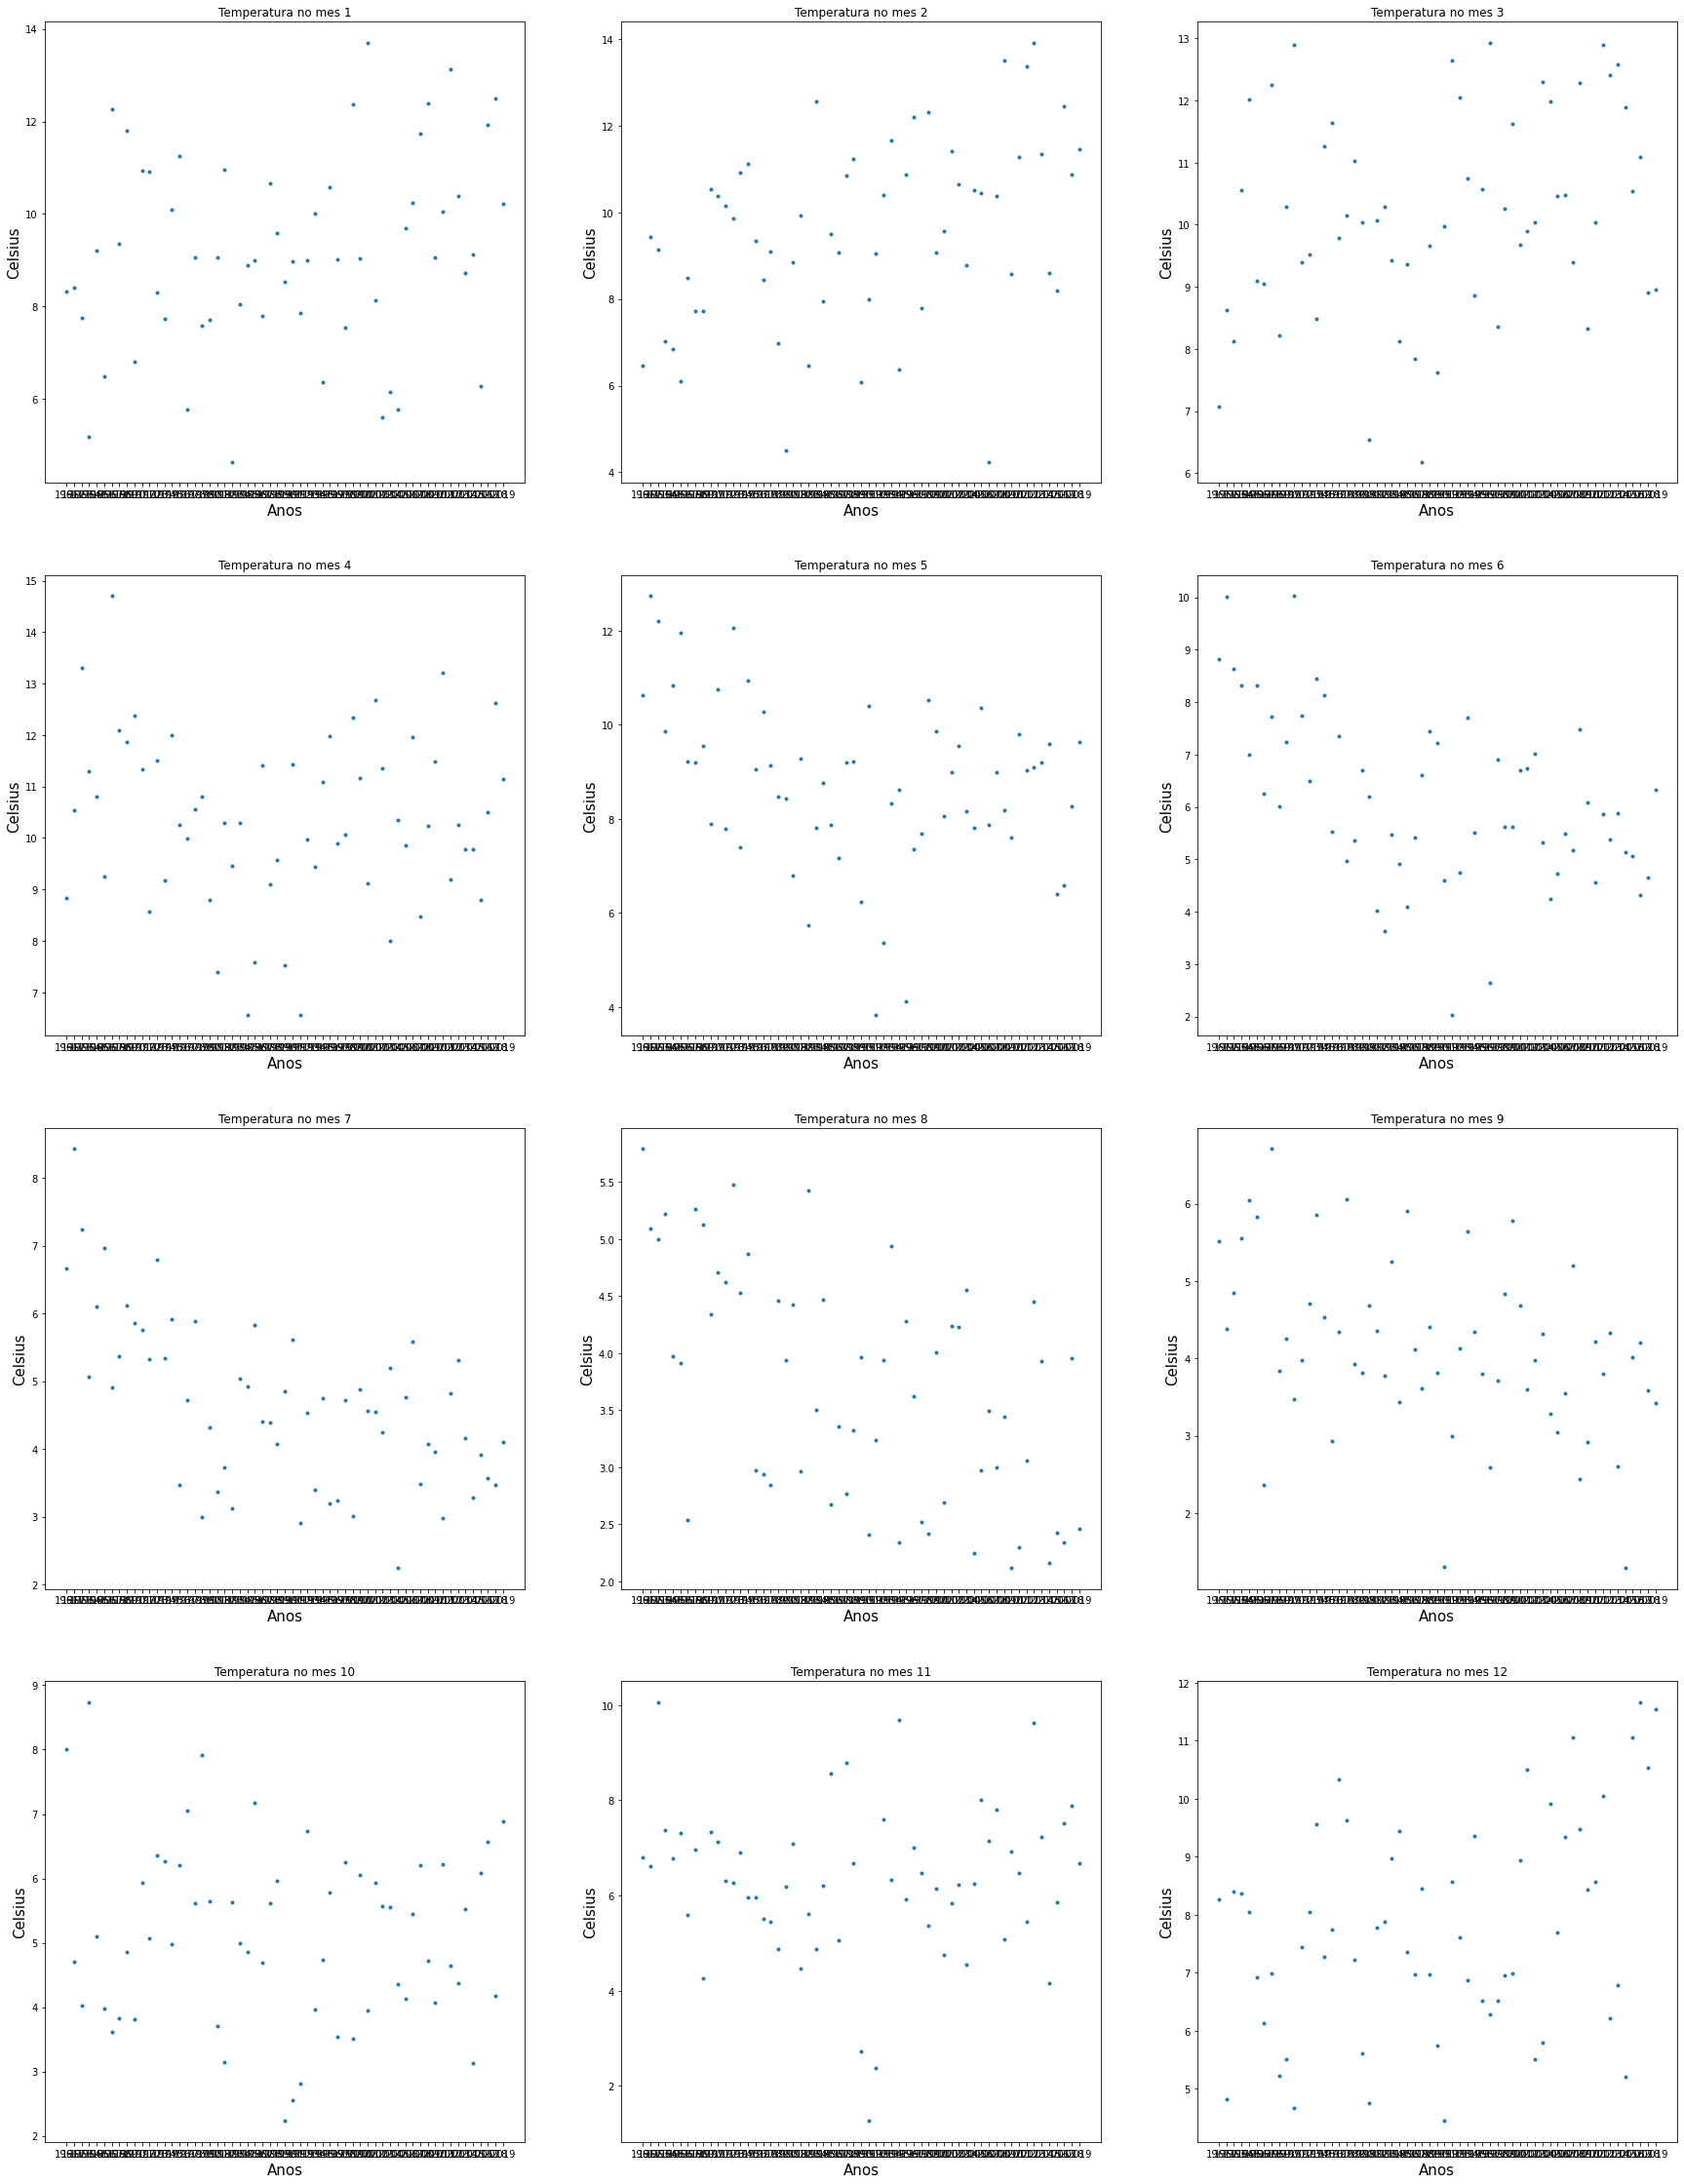

In [31]:
plt.figure(figsize=(30,40))

for mes in range(1,13,1):
    plt.subplot(4,3,mes)
    plt.plot(dfprecipitacao.index, dfprecipitacao[mes], '.')
    plt.title('Temperatura no mes ' + str(mes))
    plt.xlabel('Anos', fontsize=15)
    plt.ylabel('Celsius', fontsize=15)

#     plt.subplot(12,1,mes)
#     plt.bar(dfminima.index, dfminima[mes], width=0.7)
    
plt.show()

In [ ]:
###TESTES###

In [ ]:
dfmaxima = pd.DataFrame({'Ano': [],
                         1: [], 
                         2: [], 
                         3: [], 
                         4: [], 
                         5: [], 
                         6: [], 
                         7: [], 
                         8: [], 
                         9: [], 
                         10: [], 
                         11: [], 
                         12: []})

dfminima = pd.DataFrame({'Ano': [],
                         1: [], 
                         2: [], 
                         3: [], 
                         4: [], 
                         5: [], 
                         6: [], 
                         7: [], 
                         8: [], 
                         9: [], 
                         10: [], 
                         11: [], 
                         12: []})

dfprecipitacao = pd.DataFrame({'Ano': [],
                               1: [], 
                               2: [], 
                               3: [], 
                               4: [], 
                               5: [], 
                               6: [], 
                               7: [], 
                               8: [], 
                               9: [], 
                               10: [], 
                               11: [], 
                               12: []})


for ano in range(1961, 2020, 1):
    dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(ano)]
    dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
    dftranspose = dfano.transpose()
    dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
    dfmaxima.Ano.mask(dfmaxima.index == ano - 1961, str(ano), inplace=True)
    dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
    dfminima.Ano.mask(dfminima.index == ano - 1961, str(ano), inplace=True)
    dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
    dfprecipitacao.Ano.mask(dfprecipitacao.index == ano - 1961, str(ano), inplace=True)

In [ ]:
y = teste.iloc[:,2].values.reshape(-1, 1)  #dependent variable vector
X = teste.iloc[:,6].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score

In [ ]:
# dfmanaus = planilhaEstado[planilhaEstado.Codigo == 82331]
dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(1961)]
dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
dftranspose = dfano.transpose()
dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
dfmaxima.Ano.mask(dfmaxima.index == 1974 - 1961, str(1974), inplace=True)

dftranspose
# dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
# dfminima.Ano.mask(dfminima.index == 1974 - 1961, str(1974), inplace=True)
# dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
# dfprecipitacao.Ano.mask(dfprecipitacao.index == 1974 - 1961, str(1974), inplace=True)

In [ ]:
dfmaxima.dropna(thresh=2, inplace = True)
# media = dfmaxima[10].mean()
dfmaxima.update(dfmaxima[10].fillna(dfmaxima[10].mean()))
dfmaxima

In [ ]:
######COMPONENTES ADITIVAS E MULTIPLICATIVAS######
df = pd.DataFrame()
df['Data'] = dfMes.Data
df['Maxima'] = dfMes.TempMaxima
df = df.set_index('Data')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
from scipy.stats import shapiro
data = dfGrafico.TempMinima
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

In [ ]:
###Exponential Smoothing de primeira e segunda ordem###
##SIMPLE
modelo = SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False,use_brute=True)

##DOUBLE
modelo = ExponentialSmoothing(train, trend='add').fit()
predicao = modelo.forecast(108)